# Project 16 

In [8]:
from time import time
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [10]:
num_classes = 2
input_shape = (300, 300, 3)
dataset_name = "horses_or_humans"
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE
(train_ds, test_ds), metadata = tfds.load(name = dataset_name, split=[tfds.Split.TRAIN, tfds.Split.TEST], 
                                         with_info=True, as_supervised=True)
print(f"Image shape: {metadata.features['image'].shape}")
print(f"Training images: {metadata.splits['train'].num_examples}")
print(f"Test images: {metadata.splits['test'].num_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling horses_or_humans-train.tfrecord...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling horses_or_humans-test.tfrecord...:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to C:\Users\jatin\tensorflow_datasets\horses_or_humans\3.0.0. Subsequent calls will reuse this data.
Image shape: (300, 300, 3)
Training images: 1027
Test images: 256


In [15]:
rescale = layers.Rescaling(1.0 / 255)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
])
def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)

In [19]:
model = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(300, 300, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Dropout(0.5),
    layers.MaxPooling2D(2, 2), 
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [20]:
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        grads = []
        gradients = super().get_gradient()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)
        return grads
optimizer = GCRMSprop(learning_rate=1e-4)

In [21]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)
        

In [22]:
time_callback_no_gc = TimeHistory()
model.compile(loss="binary_crossentropy", optimizer=RMSprop(learning_rate=1e-4), metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 dropout_3 (Dropout)         (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)       

In [23]:
history_no_gc = model.fit(train_ds, epochs=10, verbose=1, callbacks=[time_callback_no_gc])

Epoch 1/10
9/9 [==============================] - 95s 9s/step - loss: 0.7396 - accuracy: 0.5463
Epoch 2/10
9/9 [==============================] - 89s 8s/step - loss: 0.6995 - accuracy: 0.5424
Epoch 3/10
9/9 [==============================] - 89s 8s/step - loss: 0.6967 - accuracy: 0.5813
Epoch 4/10
9/9 [==============================] - 90s 9s/step - loss: 0.6560 - accuracy: 0.6290
Epoch 5/10
9/9 [==============================] - 89s 8s/step - loss: 0.6446 - accuracy: 0.6524
Epoch 6/10
9/9 [==============================] - 89s 9s/step - loss: 0.6666 - accuracy: 0.6329
Epoch 7/10
9/9 [==============================] - 89s 9s/step - loss: 0.6164 - accuracy: 0.6680
Epoch 8/10
9/9 [==============================] - 90s 9s/step - loss: 0.6165 - accuracy: 0.6650
Epoch 9/10
9/9 [==============================] - 90s 9s/step - loss: 0.5867 - accuracy: 0.6913
Epoch 10/10
9/9 [==============================] - 91s 9s/step - loss: 0.5625 - accuracy: 0.7429


In [24]:
time_callback_gc = TimeHistory()
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print(model.summary())
history_gc = model.fit(train_ds, epochs=10, verbose=1, callbacks=[time_callback_gc])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 dropout_3 (Dropout)         (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)       

In [25]:
print("Not using Gradient Centralization")
print(f"Loss: {history_no_gc.history['loss'][-1]}")
print(f"Accuracy: {history_no_gc.history['accuracy'][-1]}")
print(f"Training Time: {sum(time_callback_no_gc.times)}")
print("using Gradient Centralization")
print(f"Loss: {history_gc.history['loss'][-1]}")
print(f"Accuracy: {history_gc.history['accuracy'][-1]}")
print(f"Training Time: {sum(time_callback_gc.times)}")

Not using Gradient Centralization
Loss: 0.5624661445617676
Accuracy: 0.7429406046867371
Training Time: 900.0019562244415
using Gradient Centralization
Loss: 0.47238343954086304
Accuracy: 0.8159688115119934
Training Time: 897.6118202209473


# Projects 17

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(f"x_train shape: {x_train.shape} - y_train.shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train.shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] 

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [7]:
import matplotlib.pyplot as plt

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


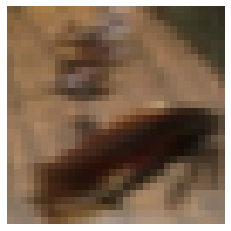

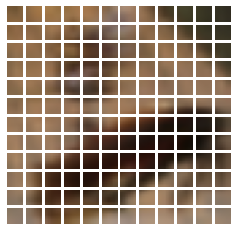

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics=[
                     keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                     keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
                 ])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]']                
                                                                                                  
 patches_2 (Patches)            (None, None, 108)    0           ['data_augmentation[1][0]']      
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 144, 64)     16192       ['patches_2[0][0]']              
                                                                                            

 multi_head_attention_11 (Multi  (None, 144, 64)     66368       ['layer_normalization_23[0][0]', 
 HeadAttention)                                                   'layer_normalization_23[0][0]'] 
                                                                                                  
 add_22 (Add)                   (None, 144, 64)      0           ['multi_head_attention_11[0][0]',
                                                                  'add_21[0][0]']                 
                                                                                                  
 layer_normalization_24 (LayerN  (None, 144, 64)     128         ['add_22[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_27 (Dense)               (None, 144, 128)     8320        ['layer_normalization_24[0][0]'] 
          

                                                                                                  
 dropout_32 (Dropout)           (None, 144, 64)      0           ['dense_34[0][0]']               
                                                                                                  
 add_29 (Add)                   (None, 144, 64)      0           ['dropout_32[0][0]',             
                                                                  'add_28[0][0]']                 
                                                                                                  
 layer_normalization_31 (LayerN  (None, 144, 64)     128         ['add_29[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_15 (Multi  (None, 144, 64)     66368       ['layer_normalization_31[0][0]', 
 HeadAtten

In [15]:
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 2775s 16s/step - loss: 4.4668 - accuracy: 0.0467 - top-5-accuracy: 0.1634 - val_loss: 3.9300 - val_accuracy: 0.0982 - val_top-5-accuracy: 0.3098
Epoch 2/100
176/176 [==============================] - 2397s 14s/step - loss: 3.9387 - accuracy: 0.0978 - top-5-accuracy: 0.2951 - val_loss: 3.5490 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.4148
Epoch 3/100
176/176 [==============================] - 2397s 14s/step - loss: 3.6790 - accuracy: 0.1336 - top-5-accuracy: 0.3696 - val_loss: 3.3516 - val_accuracy: 0.1968 - val_top-5-accuracy: 0.4684
Epoch 4/100
176/176 [==============================] - 2407s 14s/step - loss: 3.4994 - accuracy: 0.1644 - top-5-accuracy: 0.4235 - val_loss: 3.2107 - val_accuracy: 0.2206 - val_top-5-accuracy: 0.5102
Epoch 5/100
176/176 [==============================] - 2387s 14s/step - loss: 3.3677 - accuracy: 0.1881 - top-5-accuracy: 0.4614 - val_loss: 3.0434 - val_accuracy: 0.2560 - val_top-5-accuracy: 0.5584


Epoch 42/100
176/176 [==============================] - 2458s 14s/step - loss: 1.3411 - accuracy: 0.6167 - top-5-accuracy: 0.8889 - val_loss: 1.8813 - val_accuracy: 0.5130 - val_top-5-accuracy: 0.7984
Epoch 43/100
176/176 [==============================] - 2447s 14s/step - loss: 1.3098 - accuracy: 0.6257 - top-5-accuracy: 0.8936 - val_loss: 1.8886 - val_accuracy: 0.5074 - val_top-5-accuracy: 0.7946
Epoch 44/100
176/176 [==============================] - 2440s 14s/step - loss: 1.3043 - accuracy: 0.6272 - top-5-accuracy: 0.8959 - val_loss: 1.8667 - val_accuracy: 0.5168 - val_top-5-accuracy: 0.7958
Epoch 45/100
176/176 [==============================] - 2430s 14s/step - loss: 1.2590 - accuracy: 0.6332 - top-5-accuracy: 0.9026 - val_loss: 1.8836 - val_accuracy: 0.5154 - val_top-5-accuracy: 0.7944
Epoch 46/100
176/176 [==============================] - 2433s 14s/step - loss: 1.2573 - accuracy: 0.6381 - top-5-accuracy: 0.9015 - val_loss: 1.8638 - val_accuracy: 0.5184 - val_top-5-accuracy: 0.

Epoch 83/100
176/176 [==============================] - 2428s 14s/step - loss: 0.8498 - accuracy: 0.7466 - top-5-accuracy: 0.9532 - val_loss: 1.9052 - val_accuracy: 0.5294 - val_top-5-accuracy: 0.8110
Epoch 84/100
176/176 [==============================] - 2437s 14s/step - loss: 0.8354 - accuracy: 0.7480 - top-5-accuracy: 0.9550 - val_loss: 1.9415 - val_accuracy: 0.5358 - val_top-5-accuracy: 0.8096
Epoch 85/100
176/176 [==============================] - 2428s 14s/step - loss: 0.8338 - accuracy: 0.7490 - top-5-accuracy: 0.9549 - val_loss: 1.9207 - val_accuracy: 0.5356 - val_top-5-accuracy: 0.8160
Epoch 86/100
176/176 [==============================] - 2424s 14s/step - loss: 0.8453 - accuracy: 0.7478 - top-5-accuracy: 0.9537 - val_loss: 1.9418 - val_accuracy: 0.5374 - val_top-5-accuracy: 0.8108
Epoch 87/100
176/176 [==============================] - 2440s 14s/step - loss: 0.8305 - accuracy: 0.7508 - top-5-accuracy: 0.9554 - val_loss: 1.9451 - val_accuracy: 0.5312 - val_top-5-accuracy: 0.

# Projects 18

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
tf.random.set_seed(42)

In [4]:
class Involution(keras.layers.Layer):
    def __init__(self, channel, group_number, kernel_size, stride, reduction_ratio, name):
        super().__init__(name=name)
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio
    def build(self, input_shape):
        (_, height, width, num_channels) = input_shape
        height = height // self.stride
        width = width // self.stride
        self.stride_layer = (keras.layers.AveragePooling2D(pool_size=self.stride, strides=self.stride, padding="same")
                            if self.stride > 1 else tf.identity)
        self.kernel_gen = keras.Sequential([
            keras.layers.Conv2D(filters=self.channel // self.reduction_ratio, kernel_size=1),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Conv2D(filters=self.kernel_size * self.kernel_size * self.group_number, kernel_size=1)
        ])
        self.kernel_reshape = keras.layers.Reshape(target_shape=(height, width, 
                                                                 self.kernel_size * self.kernel_size, 1, 
                                                                 self.group_number))
        self.input_patches_reshape = keras.layers.Reshape(target_shape=(height, width, 
                            self.kernel_size * self.kernel_size, num_channels // self.group_number, self.group_number))
        self.output_reshape = keras.layers.Reshape(target_shape=(height, width, num_channels))
    def call(self, x):
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)
        kernel = self.kernel_reshape(kernel)
        input_patches = tf.image.extract_patches(images=x, sizes=[1, self.kernel_size, self.kernel_size, 1], 
                                                strides=[1, self.stride, self.stride, 1], rates=[1, 1, 1, 1],
                                                padding="SAME")
        input_patches = self.input_patches_reshape(input_patches)
        output = tf.multiply(kernel, input_patches)
        output = tf.reduce_sum(output, axis=3)
        output = self.output_reshape(output)
        return output, kernel

In [5]:
input_tensor = tf.random.normal((32, 256, 256, 3))
output_tensor, _ = Involution(channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, 
                              name="inv_1")(input_tensor)
print(f"with stride 1 output shape: {output_tensor.shape}")
output_tensor, _ = Involution(channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1,
                             name="inv_2")(input_tensor)
print(f"with stride 2 output shape: {output_tensor.shape}")

output_tensor, _ = Involution(channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, 
                              name="inv_3")(input_tensor)
print("with channel 16 and reduction ratio 2 output shape: {}".format(output_tensor.shape))

with stride 1 output shape: (32, 256, 256, 3)
with stride 2 output shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 output shape: (32, 256, 256, 3)


In [8]:
print("loading the CIFAR10 dataset...")
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)
train_ds = (tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(256).batch(256))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)

loading the CIFAR10 dataset...


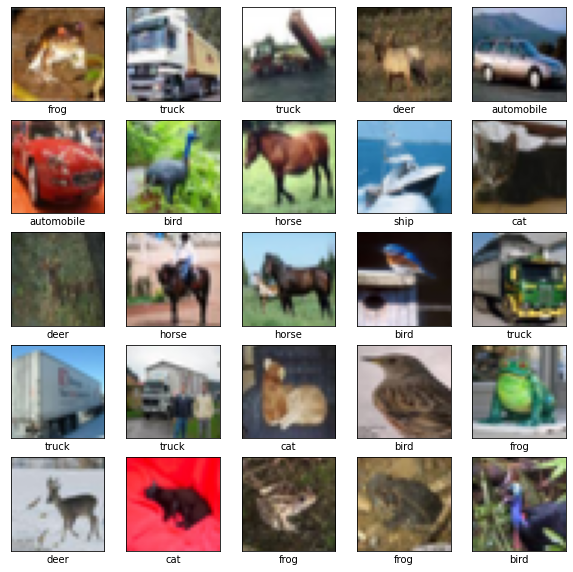

In [9]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [10]:
print("Building the convolution model...")
conv_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding="same"),
    keras.layers.ReLU(name="relu1"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding="same"),
    keras.layers.ReLU(name="relu2"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding="same"), 
    keras.layers.ReLU(name="relu3"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10)
])
print("compiling the convolutional model...")
conv_model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=["accuracy"])
print("conv model training....")
conv_hist = conv_model.fit(train_ds, epochs=20, validation_data=test_ds)

Building the convolution model...
compiling the convolutional model...
conv model training....
Epoch 1/20
196/196 [==============================] - 71s 358ms/step - loss: 1.6708 - accuracy: 0.3986 - val_loss: 1.3804 - val_accuracy: 0.5024
Epoch 2/20
196/196 [==============================] - 70s 358ms/step - loss: 1.2778 - accuracy: 0.5453 - val_loss: 1.1748 - val_accuracy: 0.5857
Epoch 3/20
196/196 [==============================] - 70s 358ms/step - loss: 1.1279 - accuracy: 0.6029 - val_loss: 1.0741 - val_accuracy: 0.6182
Epoch 4/20
196/196 [==============================] - 71s 361ms/step - loss: 1.0145 - accuracy: 0.6456 - val_loss: 0.9913 - val_accuracy: 0.6513
Epoch 5/20
196/196 [==============================] - 70s 358ms/step - loss: 0.9260 - accuracy: 0.6760 - val_loss: 0.9368 - val_accuracy: 0.6753
Epoch 6/20
196/196 [==============================] - 70s 357ms/step - loss: 0.8633 - accuracy: 0.6993 - val_loss: 0.8996 - val_accuracy: 0.6864
Epoch 7/20
196/196 [===============

In [11]:
print("building the involution model...")
inputs = keras.Input(shape=(32, 32, 3))
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1")(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)
inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")
print("compiling the invlution model...")
inv_model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=["accuracy"])
print("inv model training...")
inf_hist = inv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the involution model...
compiling the invlution model...
inv model training...
Epoch 1/20
196/196 [==============================] - 74s 359ms/step - loss: 2.1113 - accuracy: 0.2458 - val_loss: 2.0941 - val_accuracy: 0.2536
Epoch 2/20
196/196 [==============================] - 70s 355ms/step - loss: 1.8616 - accuracy: 0.3514 - val_loss: 1.8085 - val_accuracy: 0.3638
Epoch 3/20
196/196 [==============================] - 70s 356ms/step - loss: 1.7801 - accuracy: 0.3781 - val_loss: 1.7833 - val_accuracy: 0.3749
Epoch 4/20
196/196 [==============================] - 69s 353ms/step - loss: 1.7359 - accuracy: 0.3955 - val_loss: 1.7185 - val_accuracy: 0.4018
Epoch 5/20
196/196 [==============================] - 70s 355ms/step - loss: 1.6990 - accuracy: 0.4078 - val_loss: 1.6931 - val_accuracy: 0.4118
Epoch 6/20
196/196 [==============================] - 70s 355ms/step - loss: 1.6740 - accuracy: 0.4166 - val_loss: 1.6751 - val_accuracy: 0.4174
Epoch 7/20
196/196 [======================

In [12]:
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 relu1 (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 relu2 (ReLU)                (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [13]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 inv_1 (Involution)          ((None, 32, 32, 3),       26        
                              (None, 32, 32, 9, 1, 1)            
                             )                                   
                                                                 
 re_lu_4 (ReLU)              (None, 32, 32, 3)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 3)        0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 16, 16, 3),       26        
                              (None, 16, 16, 9, 1, 1)    

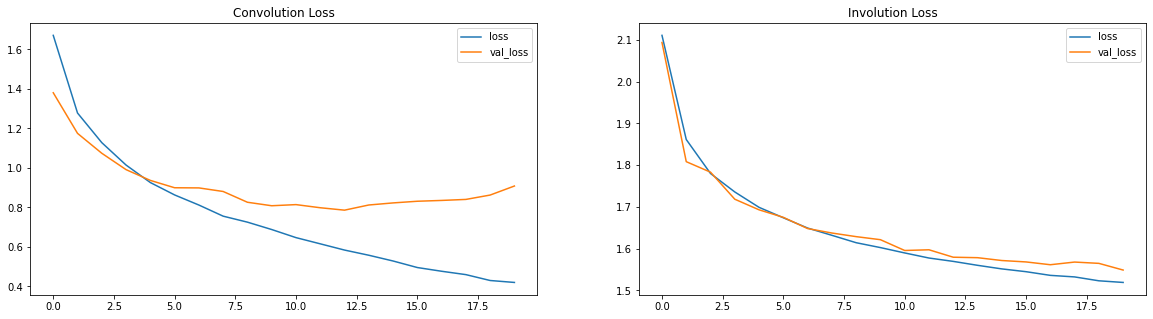

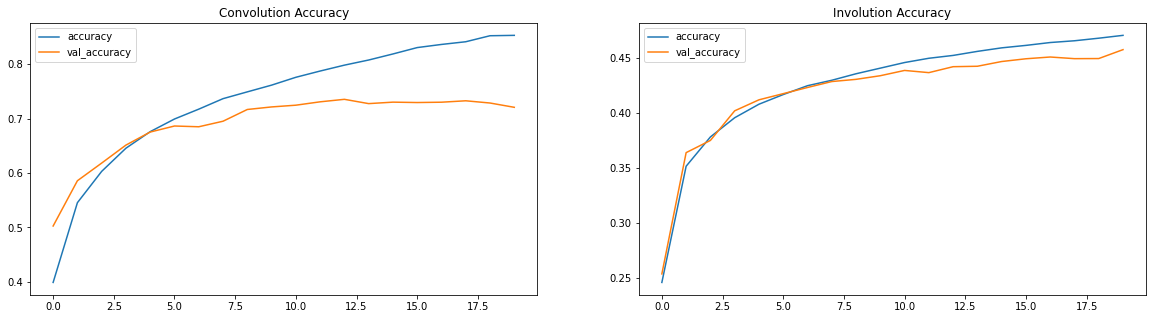

In [15]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inf_hist.history["loss"], label="loss")
plt.plot(inf_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inf_hist.history["accuracy"], label="accuracy")
plt.plot(inf_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

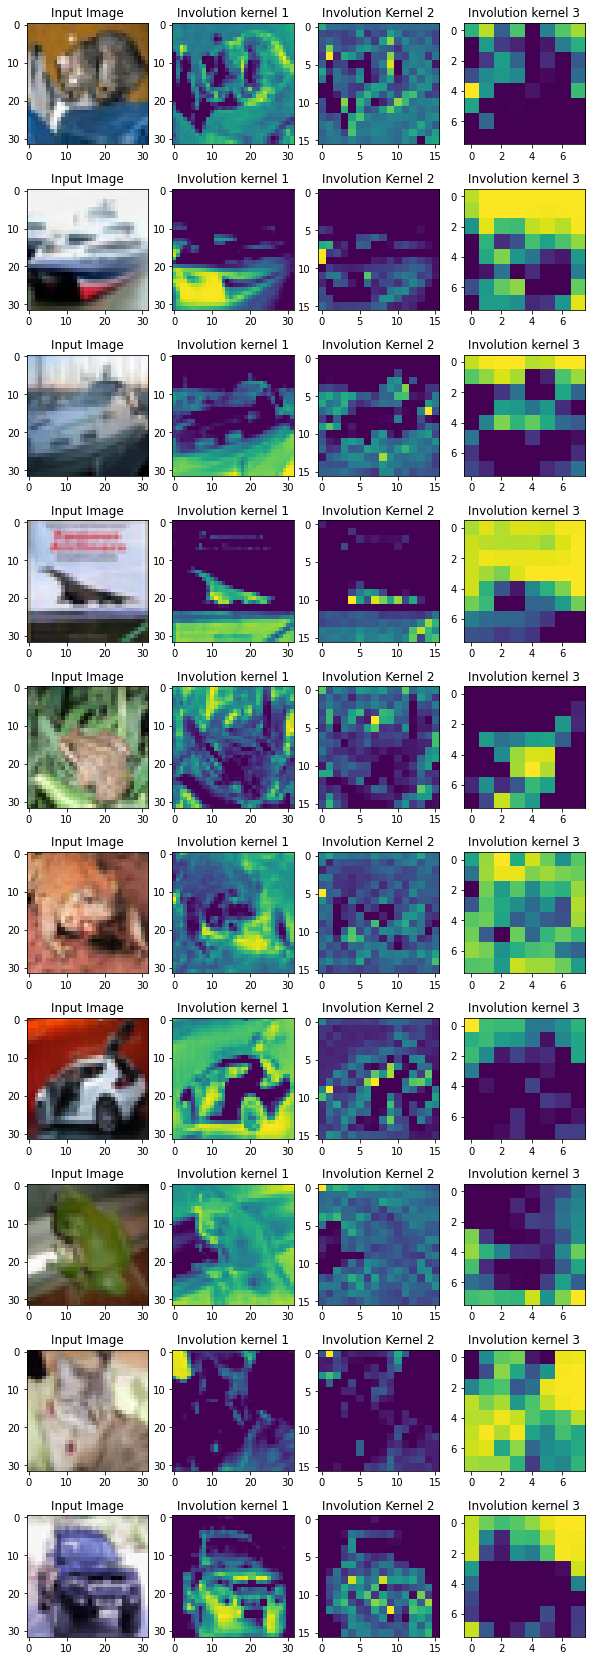

In [19]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output for name in layer_names]
vis_model = keras.Model(inv_model.input, outputs)
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))
for ax, test_image in zip(axes, test_images[:10]):
    (inv1_out, inv2_out, inv3_out) = vis_model.predict(test_image[None, ...])
    _, inv1_kernel = inv1_out
    _, inv2_kernel = inv2_out
    _, inv3_kernel = inv3_out
    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])
    ax[0].imshow(keras.preprocessing.image.array_to_img(test_image))
    ax[0].set_title("Input Image")
    
    ax[1].imshow(keras.preprocessing.image.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution kernel 1")
    
    ax[2].imshow(keras.preprocessing.image.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")
    
    ax[3].imshow(keras.preprocessing.image.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution kernel 3")

# Project 19

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [27]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(tf.nn.softmax(teacher_predictions / self.temperature, axis=1), 
                                                         tf.nn.softmax(student_predictions / self.temperature, axis=1))
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss":distillation_loss})
        return results
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [28]:
teacher = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"), 
    layers.Flatten(),
    layers.Dense(10)
], name="teacher")
student = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.Flatten(),
    layers.Dense(10)
], name="student")
student_scratch = keras.models.clone_model(student)

In [29]:
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [32]:
teacher.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics=[keras.metrics.SparseCategoricalAccuracy()])
teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 349s 186ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9575
Epoch 2/5
1875/1875 [==============================] - 354s 189ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9730
Epoch 3/5
1875/1875 [==============================] - 356s 190ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 358s 191ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9797
Epoch 5/5
313/313 [==============================] - 12s 38ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9755


[0.09733350574970245, 0.9754999876022339]

In [34]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.SparseCategoricalAccuracy()], 
                 student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 distillation_loss_fn = keras.losses.KLDivergence(), alpha=0.1, temperature=10)
distiller.fit(x_train, y_train, epochs=3)
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 69s 37ms/step - sparse_categorical_accuracy: 0.9208 - student_loss: 0.3507 - distillation_loss: 0.1022
Epoch 2/3
1875/1875 [==============================] - 70s 37ms/step - sparse_categorical_accuracy: 0.9696 - student_loss: 0.1268 - distillation_loss: 0.0306
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.9760 - student_loss: 0.0942


[0.9760000109672546, 0.007936337031424046]

In [35]:
student_scratch.compile(optimizer=keras.optimizers.Adam(), 
                        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                       metrics=[keras.metrics.SparseCategoricalAccuracy()])
student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2475 - sparse_categorical_accuracy: 0.9259
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9687
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9800


[0.0619763545691967, 0.9800000190734863]

# Project 20

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa
import random
seed = 42
keras.utils.set_random_seed(seed)

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [53]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [54]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:])
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)
test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [55]:
def get_train_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE), 
        layers.RandomFlip("horizontal")
    ], name="train_data_augmentation")
    return model
def get_test_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1 / 255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
    ], name="test_data_augmentation")
    return model

In [56]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 188.


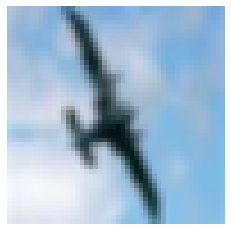

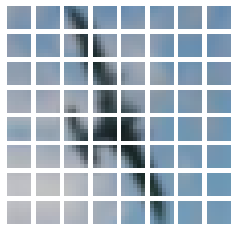

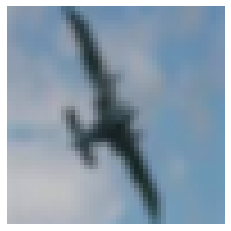

In [57]:
image_batch = next(iter(train_ds))
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)
patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [58]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

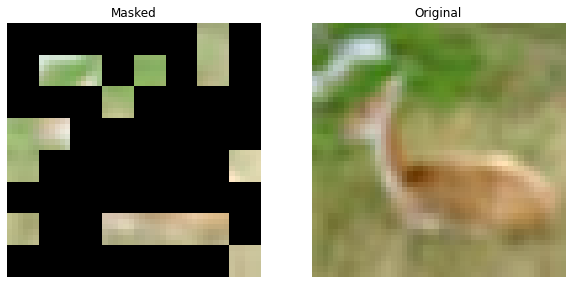

In [59]:
patch_encoder = PatchEncoder()
(unmasked_embeddings, masked_embeddings, unmasked_positions, 
 mask_indices, unmask_indices) = patch_encoder(patches=patches)
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [60]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [61]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [62]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [63]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [64]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [65]:
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

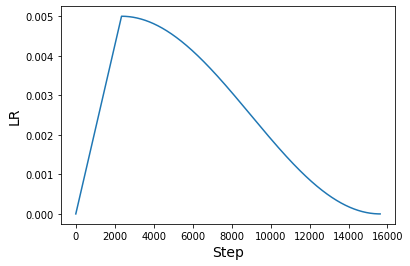

In [66]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.0504 - mae: 0.1801
Idx chosen: 102


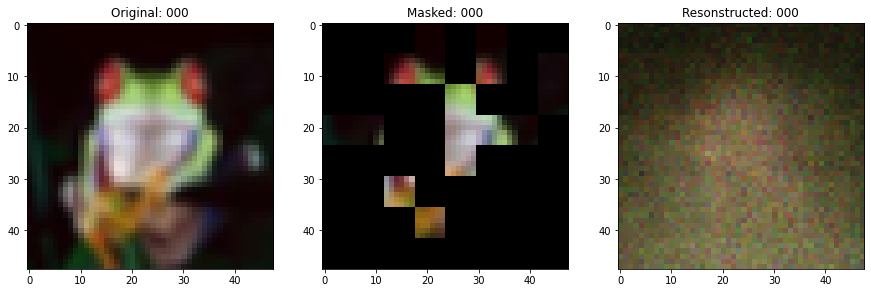

157/157 [==============================] - 694s 4s/step - loss: 0.0504 - mae: 0.1801 - val_loss: 0.0402 - val_mae: 0.1589
Epoch 2/100
157/157 [==============================] - 663s 4s/step - loss: 0.0378 - mae: 0.1532 - val_loss: 0.0356 - val_mae: 0.1471
Epoch 3/100
157/157 [==============================] - 667s 4s/step - loss: 0.0322 - mae: 0.1383 - val_loss: 0.0316 - val_mae: 0.1347
Epoch 4/100
157/157 [==============================] - 601s 4s/step - loss: 0.0291 - mae: 0.1300 - val_loss: 0.0290 - val_mae: 0.1295
Epoch 5/100
157/157 [==============================] - 467s 3s/step - loss: 0.0266 - mae: 0.1233 - val_loss: 0.0263 - val_mae: 0.1224
Epoch 6/100
157/157 [==============================] - ETA: 0s - loss: 0.0242 - mae: 0.1168
Idx chosen: 121


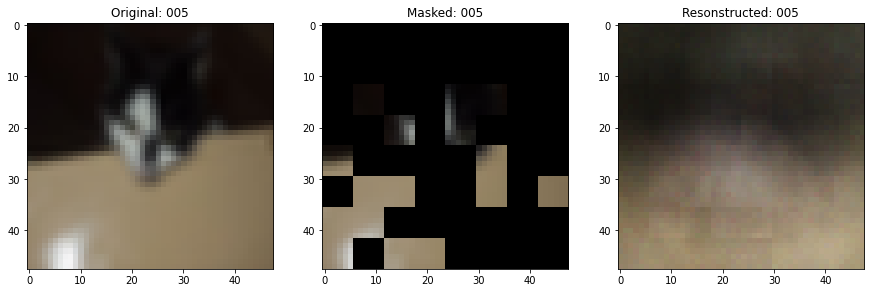

157/157 [==============================] - 477s 3s/step - loss: 0.0242 - mae: 0.1168 - val_loss: 0.0238 - val_mae: 0.1157
Epoch 7/100
157/157 [==============================] - 492s 3s/step - loss: 0.0226 - mae: 0.1122 - val_loss: 0.0239 - val_mae: 0.1168
Epoch 8/100
157/157 [==============================] - 484s 3s/step - loss: 0.0216 - mae: 0.1093 - val_loss: 0.0238 - val_mae: 0.1142
Epoch 9/100
157/157 [==============================] - 489s 3s/step - loss: 0.0207 - mae: 0.1066 - val_loss: 0.0210 - val_mae: 0.1079
Epoch 10/100
157/157 [==============================] - 473s 3s/step - loss: 0.0201 - mae: 0.1049 - val_loss: 0.0208 - val_mae: 0.1059
Epoch 11/100
157/157 [==============================] - ETA: 0s - loss: 0.0195 - mae: 0.1030
Idx chosen: 210


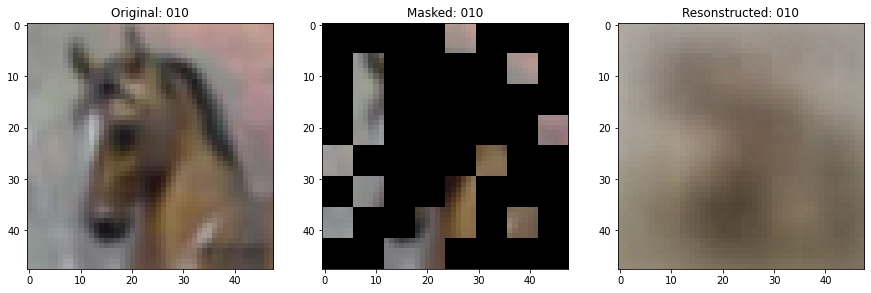

157/157 [==============================] - 487s 3s/step - loss: 0.0195 - mae: 0.1030 - val_loss: 0.0202 - val_mae: 0.1053
Epoch 12/100
157/157 [==============================] - 480s 3s/step - loss: 0.0335 - mae: 0.1374 - val_loss: 0.0588 - val_mae: 0.2010
Epoch 13/100
157/157 [==============================] - 485s 3s/step - loss: 0.0516 - mae: 0.1857 - val_loss: 0.0474 - val_mae: 0.1796
Epoch 14/100
157/157 [==============================] - 480s 3s/step - loss: 0.0428 - mae: 0.1667 - val_loss: 0.0439 - val_mae: 0.1699
Epoch 15/100
157/157 [==============================] - 477s 3s/step - loss: 0.0371 - mae: 0.1522 - val_loss: 0.0340 - val_mae: 0.1436
Epoch 16/100
157/157 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.1402
Idx chosen: 214


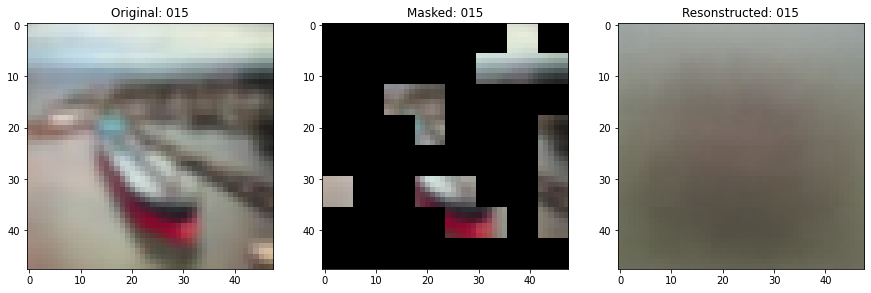

157/157 [==============================] - 493s 3s/step - loss: 0.0326 - mae: 0.1402 - val_loss: 0.0326 - val_mae: 0.1395
Epoch 17/100
157/157 [==============================] - 482s 3s/step - loss: 0.0306 - mae: 0.1347 - val_loss: 0.0298 - val_mae: 0.1334
Epoch 18/100
157/157 [==============================] - 481s 3s/step - loss: 0.0286 - mae: 0.1295 - val_loss: 0.0278 - val_mae: 0.1268
Epoch 19/100
157/157 [==============================] - 473s 3s/step - loss: 0.0269 - mae: 0.1245 - val_loss: 0.0266 - val_mae: 0.1243
Epoch 20/100
157/157 [==============================] - 471s 3s/step - loss: 0.0257 - mae: 0.1213 - val_loss: 0.0262 - val_mae: 0.1227
Epoch 21/100
157/157 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.1200
Idx chosen: 74


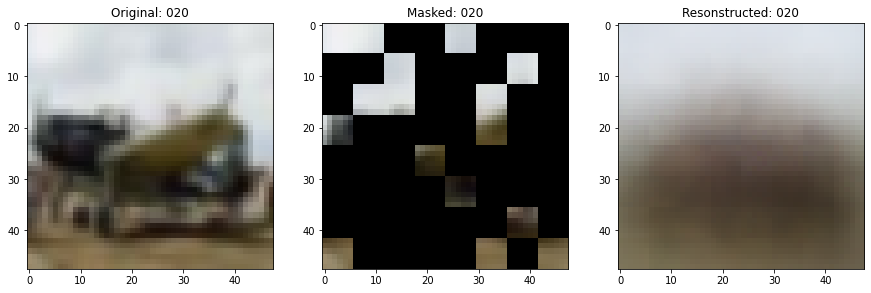

157/157 [==============================] - 477s 3s/step - loss: 0.0253 - mae: 0.1200 - val_loss: 0.0254 - val_mae: 0.1201
Epoch 22/100
157/157 [==============================] - 476s 3s/step - loss: 0.0247 - mae: 0.1184 - val_loss: 0.0252 - val_mae: 0.1198
Epoch 23/100
157/157 [==============================] - 480s 3s/step - loss: 0.0243 - mae: 0.1172 - val_loss: 0.0250 - val_mae: 0.1191
Epoch 24/100
157/157 [==============================] - 527s 3s/step - loss: 0.0238 - mae: 0.1157 - val_loss: 0.0242 - val_mae: 0.1166
Epoch 25/100
157/157 [==============================] - 690s 4s/step - loss: 0.0234 - mae: 0.1145 - val_loss: 0.0239 - val_mae: 0.1150
Epoch 26/100
157/157 [==============================] - ETA: 0s - loss: 0.0229 - mae: 0.1130
Idx chosen: 202


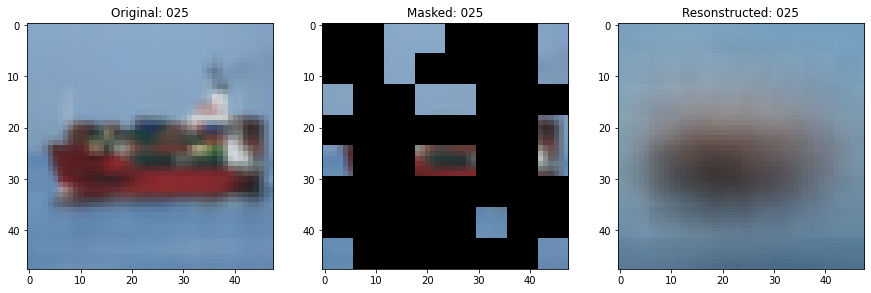

157/157 [==============================] - 675s 4s/step - loss: 0.0229 - mae: 0.1130 - val_loss: 0.0234 - val_mae: 0.1149
Epoch 27/100
157/157 [==============================] - 665s 4s/step - loss: 0.0225 - mae: 0.1118 - val_loss: 0.0226 - val_mae: 0.1112
Epoch 28/100
157/157 [==============================] - 674s 4s/step - loss: 0.0218 - mae: 0.1096 - val_loss: 0.0228 - val_mae: 0.1119
Epoch 29/100
157/157 [==============================] - 665s 4s/step - loss: 0.0216 - mae: 0.1088 - val_loss: 0.0223 - val_mae: 0.1107
Epoch 30/100
157/157 [==============================] - 664s 4s/step - loss: 0.0211 - mae: 0.1073 - val_loss: 0.0217 - val_mae: 0.1082
Epoch 31/100
157/157 [==============================] - ETA: 0s - loss: 0.0208 - mae: 0.1065
Idx chosen: 87


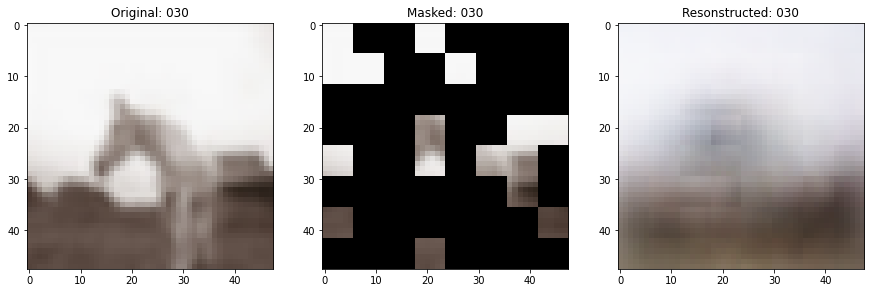

157/157 [==============================] - 665s 4s/step - loss: 0.0208 - mae: 0.1065 - val_loss: 0.0213 - val_mae: 0.1075
Epoch 32/100
157/157 [==============================] - 524s 3s/step - loss: 0.0207 - mae: 0.1062 - val_loss: 0.0219 - val_mae: 0.1102
Epoch 33/100
157/157 [==============================] - 480s 3s/step - loss: 0.0205 - mae: 0.1054 - val_loss: 0.0217 - val_mae: 0.1081
Epoch 34/100
157/157 [==============================] - 489s 3s/step - loss: 0.0202 - mae: 0.1045 - val_loss: 0.0210 - val_mae: 0.1057
Epoch 35/100
157/157 [==============================] - 480s 3s/step - loss: 0.0199 - mae: 0.1038 - val_loss: 0.0209 - val_mae: 0.1077
Epoch 36/100
157/157 [==============================] - ETA: 0s - loss: 0.0198 - mae: 0.1032
Idx chosen: 116


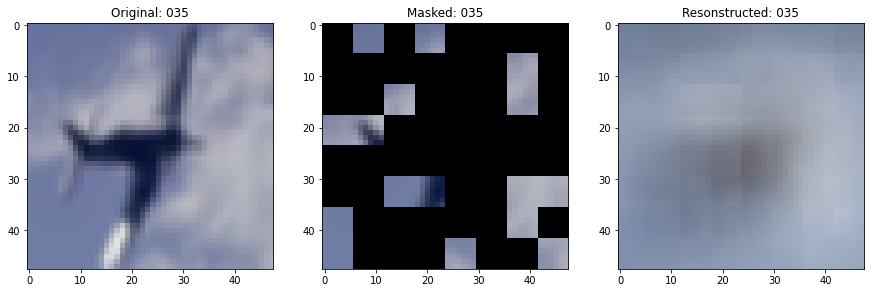

157/157 [==============================] - 497s 3s/step - loss: 0.0198 - mae: 0.1032 - val_loss: 0.0207 - val_mae: 0.1047
Epoch 37/100
157/157 [==============================] - 483s 3s/step - loss: 0.0196 - mae: 0.1028 - val_loss: 0.0202 - val_mae: 0.1046
Epoch 38/100
157/157 [==============================] - 480s 3s/step - loss: 0.0194 - mae: 0.1021 - val_loss: 0.0199 - val_mae: 0.1043
Epoch 39/100
157/157 [==============================] - 479s 3s/step - loss: 0.0195 - mae: 0.1027 - val_loss: 0.0211 - val_mae: 0.1076
Epoch 40/100
157/157 [==============================] - 471s 3s/step - loss: 0.0190 - mae: 0.1010 - val_loss: 0.0194 - val_mae: 0.1017
Epoch 41/100
157/157 [==============================] - ETA: 0s - loss: 0.0187 - mae: 0.0999
Idx chosen: 99


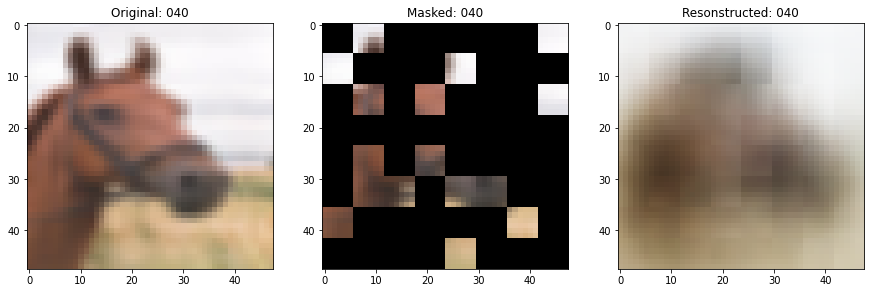

157/157 [==============================] - 474s 3s/step - loss: 0.0187 - mae: 0.0999 - val_loss: 0.0199 - val_mae: 0.1034
Epoch 42/100
157/157 [==============================] - 475s 3s/step - loss: 0.0186 - mae: 0.0996 - val_loss: 0.0192 - val_mae: 0.1005
Epoch 43/100
157/157 [==============================] - 471s 3s/step - loss: 0.0183 - mae: 0.0986 - val_loss: 0.0228 - val_mae: 0.1151
Epoch 44/100
157/157 [==============================] - 470s 3s/step - loss: 0.0184 - mae: 0.0990 - val_loss: 0.0188 - val_mae: 0.0994
Epoch 45/100
157/157 [==============================] - 470s 3s/step - loss: 0.0181 - mae: 0.0981 - val_loss: 0.0188 - val_mae: 0.0990
Epoch 46/100
157/157 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0974
Idx chosen: 103


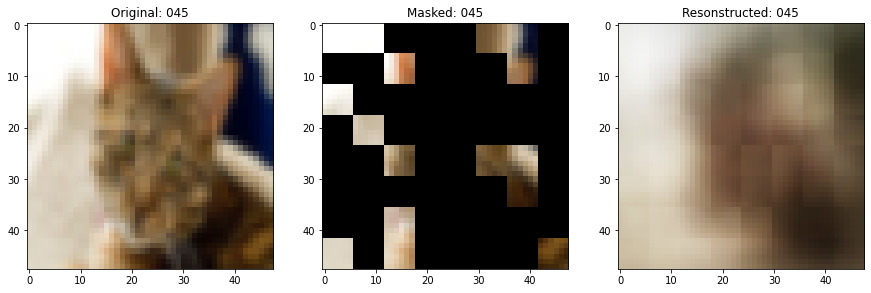

157/157 [==============================] - 477s 3s/step - loss: 0.0179 - mae: 0.0974 - val_loss: 0.0186 - val_mae: 0.0991
Epoch 47/100
157/157 [==============================] - 470s 3s/step - loss: 0.0178 - mae: 0.0970 - val_loss: 0.0191 - val_mae: 0.1010
Epoch 48/100
157/157 [==============================] - 472s 3s/step - loss: 0.0177 - mae: 0.0964 - val_loss: 0.0184 - val_mae: 0.0970
Epoch 49/100
157/157 [==============================] - 470s 3s/step - loss: 0.0178 - mae: 0.0971 - val_loss: 0.0189 - val_mae: 0.0995
Epoch 50/100
157/157 [==============================] - 474s 3s/step - loss: 0.0174 - mae: 0.0956 - val_loss: 0.0184 - val_mae: 0.0985
Epoch 51/100
157/157 [==============================] - ETA: 0s - loss: 0.0174 - mae: 0.0955
Idx chosen: 151


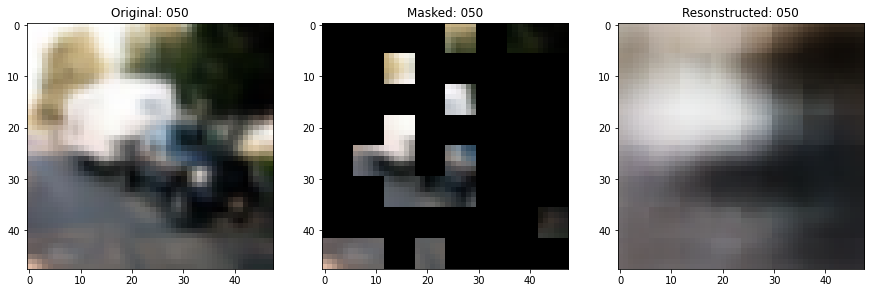

157/157 [==============================] - 473s 3s/step - loss: 0.0174 - mae: 0.0955 - val_loss: 0.0184 - val_mae: 0.0981
Epoch 52/100
157/157 [==============================] - 472s 3s/step - loss: 0.0172 - mae: 0.0949 - val_loss: 0.0182 - val_mae: 0.0961
Epoch 53/100
157/157 [==============================] - 472s 3s/step - loss: 0.0171 - mae: 0.0943 - val_loss: 0.0183 - val_mae: 0.0977
Epoch 54/100
157/157 [==============================] - 473s 3s/step - loss: 0.0171 - mae: 0.0944 - val_loss: 0.0179 - val_mae: 0.0967
Epoch 55/100
157/157 [==============================] - 470s 3s/step - loss: 0.0169 - mae: 0.0937 - val_loss: 0.0182 - val_mae: 0.0969
Epoch 56/100
157/157 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0936
Idx chosen: 130


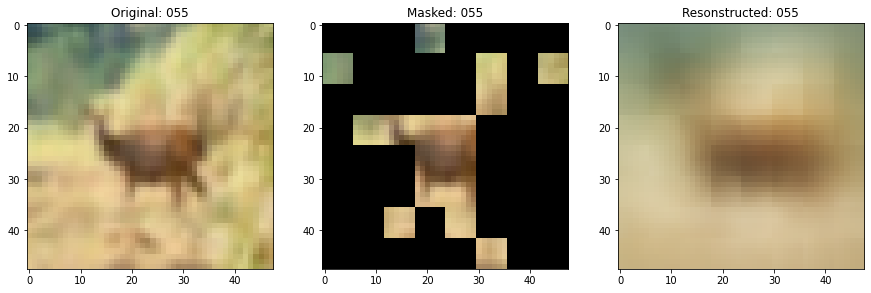

157/157 [==============================] - 471s 3s/step - loss: 0.0168 - mae: 0.0936 - val_loss: 0.0178 - val_mae: 0.0958
Epoch 57/100
157/157 [==============================] - 469s 3s/step - loss: 0.0168 - mae: 0.0934 - val_loss: 0.0175 - val_mae: 0.0951
Epoch 58/100
157/157 [==============================] - 473s 3s/step - loss: 0.0166 - mae: 0.0929 - val_loss: 0.0178 - val_mae: 0.0952
Epoch 59/100
157/157 [==============================] - 470s 3s/step - loss: 0.0166 - mae: 0.0928 - val_loss: 0.0175 - val_mae: 0.0946
Epoch 60/100
157/157 [==============================] - 475s 3s/step - loss: 0.0165 - mae: 0.0924 - val_loss: 0.0180 - val_mae: 0.0976
Epoch 61/100
157/157 [==============================] - ETA: 0s - loss: 0.0164 - mae: 0.0922
Idx chosen: 149


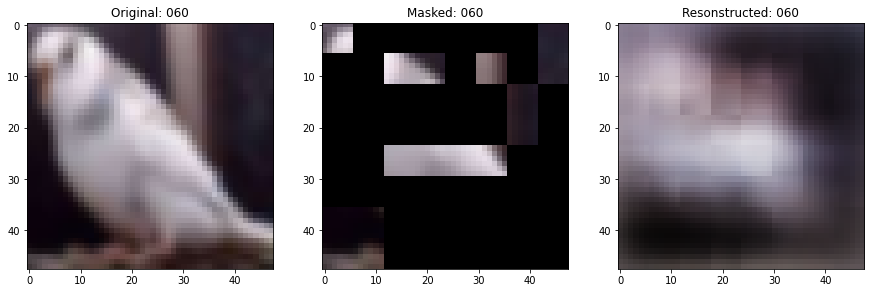

157/157 [==============================] - 479s 3s/step - loss: 0.0164 - mae: 0.0922 - val_loss: 0.0173 - val_mae: 0.0943
Epoch 62/100
157/157 [==============================] - 474s 3s/step - loss: 0.0164 - mae: 0.0920 - val_loss: 0.0178 - val_mae: 0.0953
Epoch 63/100
157/157 [==============================] - 474s 3s/step - loss: 0.0163 - mae: 0.0917 - val_loss: 0.0172 - val_mae: 0.0934
Epoch 64/100
157/157 [==============================] - 474s 3s/step - loss: 0.0163 - mae: 0.0914 - val_loss: 0.0170 - val_mae: 0.0930
Epoch 65/100
157/157 [==============================] - 479s 3s/step - loss: 0.0162 - mae: 0.0911 - val_loss: 0.0171 - val_mae: 0.0934
Epoch 66/100
157/157 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0905
Idx chosen: 52


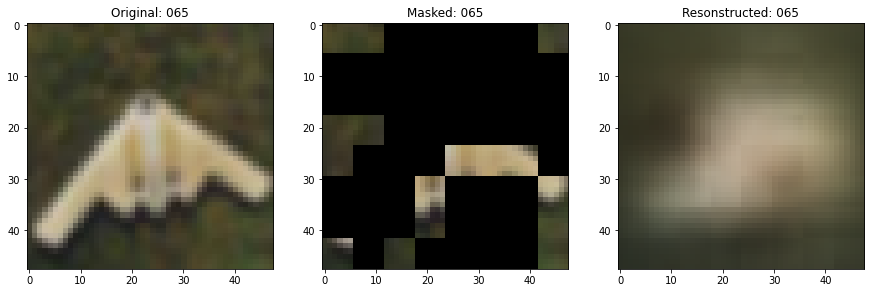

157/157 [==============================] - 479s 3s/step - loss: 0.0160 - mae: 0.0905 - val_loss: 0.0172 - val_mae: 0.0936
Epoch 67/100
157/157 [==============================] - 475s 3s/step - loss: 0.0160 - mae: 0.0905 - val_loss: 0.0169 - val_mae: 0.0922
Epoch 68/100
157/157 [==============================] - 474s 3s/step - loss: 0.0159 - mae: 0.0902 - val_loss: 0.0167 - val_mae: 0.0920
Epoch 69/100
157/157 [==============================] - 477s 3s/step - loss: 0.0158 - mae: 0.0898 - val_loss: 0.0170 - val_mae: 0.0934
Epoch 70/100
157/157 [==============================] - 474s 3s/step - loss: 0.0158 - mae: 0.0897 - val_loss: 0.0168 - val_mae: 0.0925
Epoch 71/100
157/157 [==============================] - ETA: 0s - loss: 0.0156 - mae: 0.0892
Idx chosen: 1


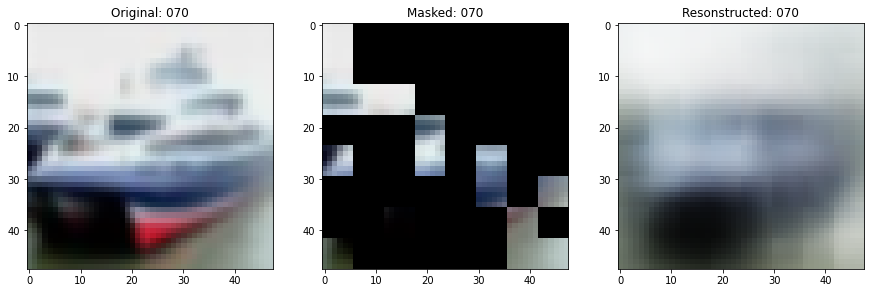

157/157 [==============================] - 477s 3s/step - loss: 0.0156 - mae: 0.0892 - val_loss: 0.0166 - val_mae: 0.0915
Epoch 72/100
157/157 [==============================] - 476s 3s/step - loss: 0.0155 - mae: 0.0889 - val_loss: 0.0166 - val_mae: 0.0919
Epoch 73/100
157/157 [==============================] - 477s 3s/step - loss: 0.0155 - mae: 0.0888 - val_loss: 0.0164 - val_mae: 0.0907
Epoch 74/100
157/157 [==============================] - 475s 3s/step - loss: 0.0154 - mae: 0.0884 - val_loss: 0.0164 - val_mae: 0.0909
Epoch 75/100
157/157 [==============================] - 475s 3s/step - loss: 0.0154 - mae: 0.0882 - val_loss: 0.0166 - val_mae: 0.0916
Epoch 76/100
157/157 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0878
Idx chosen: 87


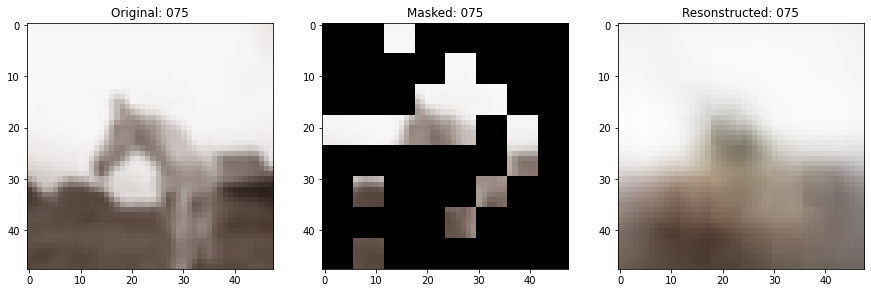

157/157 [==============================] - 478s 3s/step - loss: 0.0152 - mae: 0.0878 - val_loss: 0.0162 - val_mae: 0.0905
Epoch 77/100
157/157 [==============================] - 474s 3s/step - loss: 0.0152 - mae: 0.0878 - val_loss: 0.0161 - val_mae: 0.0897
Epoch 78/100
157/157 [==============================] - 467s 3s/step - loss: 0.0151 - mae: 0.0873 - val_loss: 0.0160 - val_mae: 0.0895
Epoch 79/100
157/157 [==============================] - 467s 3s/step - loss: 0.0151 - mae: 0.0870 - val_loss: 0.0160 - val_mae: 0.0897
Epoch 80/100
157/157 [==============================] - 471s 3s/step - loss: 0.0150 - mae: 0.0869 - val_loss: 0.0159 - val_mae: 0.0894
Epoch 81/100
157/157 [==============================] - ETA: 0s - loss: 0.0150 - mae: 0.0866
Idx chosen: 235


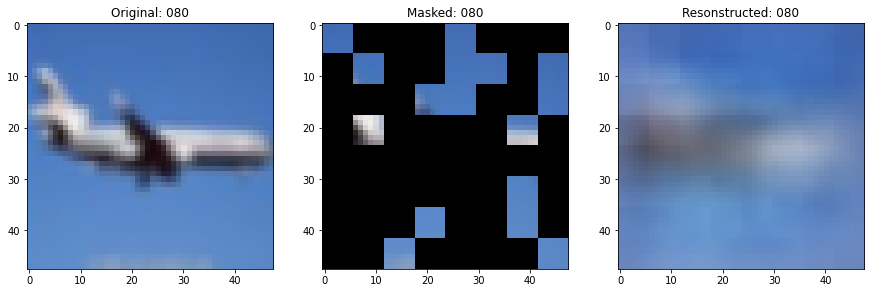

157/157 [==============================] - 471s 3s/step - loss: 0.0150 - mae: 0.0866 - val_loss: 0.0160 - val_mae: 0.0892
Epoch 82/100
157/157 [==============================] - 468s 3s/step - loss: 0.0149 - mae: 0.0865 - val_loss: 0.0160 - val_mae: 0.0894
Epoch 83/100
157/157 [==============================] - 467s 3s/step - loss: 0.0148 - mae: 0.0860 - val_loss: 0.0158 - val_mae: 0.0887
Epoch 84/100
157/157 [==============================] - 470s 3s/step - loss: 0.0148 - mae: 0.0859 - val_loss: 0.0158 - val_mae: 0.0884
Epoch 85/100
157/157 [==============================] - 468s 3s/step - loss: 0.0147 - mae: 0.0858 - val_loss: 0.0157 - val_mae: 0.0884
Epoch 86/100
157/157 [==============================] - ETA: 0s - loss: 0.0147 - mae: 0.0856
Idx chosen: 157


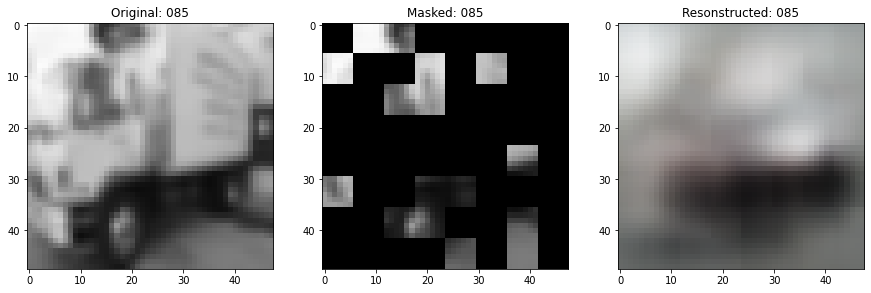

157/157 [==============================] - 469s 3s/step - loss: 0.0147 - mae: 0.0856 - val_loss: 0.0158 - val_mae: 0.0885
Epoch 87/100
157/157 [==============================] - 468s 3s/step - loss: 0.0146 - mae: 0.0853 - val_loss: 0.0156 - val_mae: 0.0882
Epoch 88/100
157/157 [==============================] - 470s 3s/step - loss: 0.0146 - mae: 0.0852 - val_loss: 0.0156 - val_mae: 0.0883
Epoch 89/100
157/157 [==============================] - 466s 3s/step - loss: 0.0146 - mae: 0.0850 - val_loss: 0.0155 - val_mae: 0.0876
Epoch 90/100
157/157 [==============================] - 468s 3s/step - loss: 0.0145 - mae: 0.0850 - val_loss: 0.0155 - val_mae: 0.0875
Epoch 91/100
157/157 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.0849
Idx chosen: 37


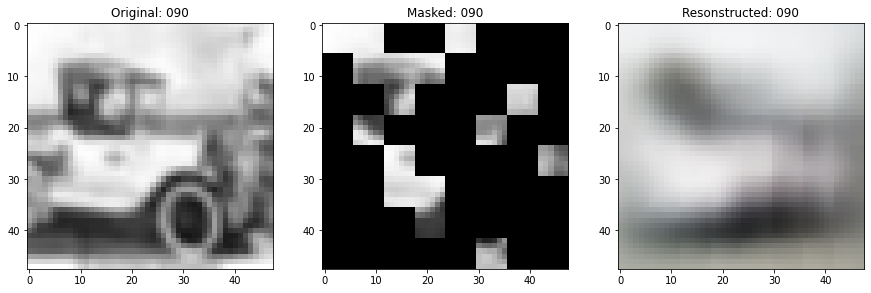

157/157 [==============================] - 469s 3s/step - loss: 0.0145 - mae: 0.0849 - val_loss: 0.0155 - val_mae: 0.0877
Epoch 92/100
157/157 [==============================] - 469s 3s/step - loss: 0.0145 - mae: 0.0847 - val_loss: 0.0155 - val_mae: 0.0876
Epoch 93/100
157/157 [==============================] - 467s 3s/step - loss: 0.0145 - mae: 0.0848 - val_loss: 0.0154 - val_mae: 0.0876
Epoch 94/100
157/157 [==============================] - 466s 3s/step - loss: 0.0145 - mae: 0.0848 - val_loss: 0.0155 - val_mae: 0.0877
Epoch 95/100
157/157 [==============================] - 466s 3s/step - loss: 0.0145 - mae: 0.0848 - val_loss: 0.0155 - val_mae: 0.0877
Epoch 96/100
157/157 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.0848
Idx chosen: 129


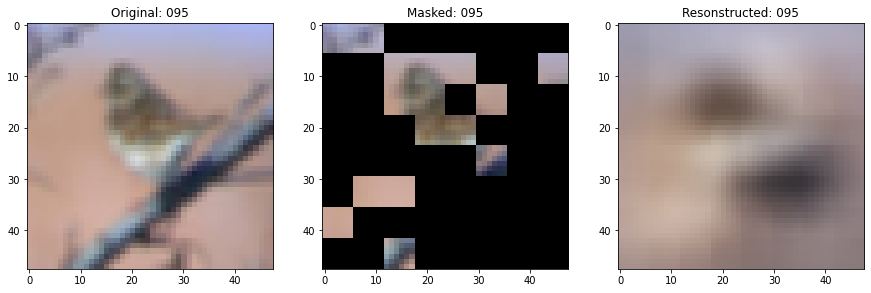

157/157 [==============================] - 472s 3s/step - loss: 0.0145 - mae: 0.0848 - val_loss: 0.0155 - val_mae: 0.0877
Epoch 97/100
157/157 [==============================] - 467s 3s/step - loss: 0.0145 - mae: 0.0849 - val_loss: 0.0155 - val_mae: 0.0877
Epoch 98/100
157/157 [==============================] - 467s 3s/step - loss: 0.0145 - mae: 0.0851 - val_loss: 0.0156 - val_mae: 0.0881
Epoch 99/100
157/157 [==============================] - 467s 3s/step - loss: 0.0146 - mae: 0.0855 - val_loss: 0.0156 - val_mae: 0.0886
Epoch 100/100
40/40 [==============================] - 37s 926ms/step - loss: 0.0160 - mae: 0.0908
Loss: 0.02
MAE: 0.09


In [67]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
mae_model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])
history = mae_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks)
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [68]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_12 (Patches)        (None, 64, 108)           0         
                                                                 
 patch_encoder_11 (PatchEnco  (None, 64, 128)          22252     
 der)                                                            
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [69]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [70]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 706s 4s/step - loss: 2.2632 - accuracy: 0.1582 - val_loss: 2.1161 - val_accuracy: 0.2656
Epoch 2/50
157/157 [==============================] - 703s 4s/step - loss: 2.0084 - accuracy: 0.3169 - val_loss: 1.8997 - val_accuracy: 0.3476
Epoch 3/50
157/157 [==============================] - 699s 4s/step - loss: 1.8616 - accuracy: 0.3575 - val_loss: 1.8055 - val_accuracy: 0.3687
Epoch 4/50
157/157 [==============================] - 700s 4s/step - loss: 1.7950 - accuracy: 0.3695 - val_loss: 1.7614 - val_accuracy: 0.3769
Epoch 5/50
157/157 [==============================] - 702s 4s/step - loss: 1.7604 - accuracy: 0.3775 - val_loss: 1.7349 - val_accuracy: 0.3862
Epoch 6/50
157/157 [==============================] - 701s 4s/step - loss: 1.7387 - accuracy: 0.3849 - val_loss: 1.7199 - val_accuracy: 0.3880
Epoch 7/50
157/157 [==============================] - 700s 4s/step - loss: 1.7241 - accuracy: 0.3871 - val_loss: 1.7084 - val_accuracy: 0.3923

# Project 21

In [73]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

In [74]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

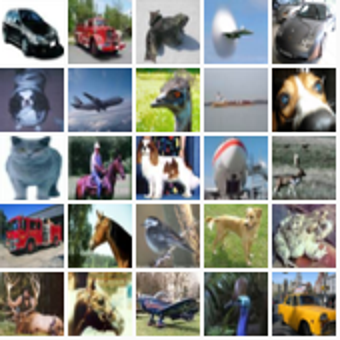

In [75]:
height_width = 32
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]
    collage = Image.new(mode="RGB", size=(num_cols * box_size, num_rows * box_size), color=(250, 250, 250))
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(Image.fromarray(array), (col_idx * box_size, row_idx * box_size))
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [76]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)
class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [81]:
num_classes = 10
class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs
    def __len__(self):
        return self.num_batchs
    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x

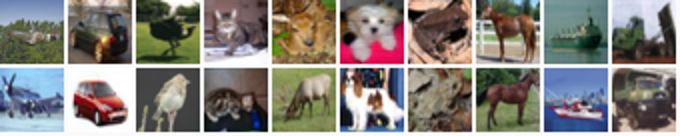

In [82]:
examples = next(iter(AnchorPositivePairs(num_batchs=1)))
show_collage(examples)

In [84]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]
        with tf.GradientTape() as tape:
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)
            similarities = tf.einsum("ae,pe->ap", anchor_embeddings, positive_embeddings)
            temperature = 0.2
            similarities /= temperature
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name:m.result() for m in self.metrics}

In [85]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)
model = EmbeddingModel(inputs, embeddings)

Epoch 1/20
1000/1000 [==============================] - 14s 12ms/step - loss: 2.2758
Epoch 2/20
1000/1000 [==============================] - 12s 12ms/step - loss: 2.1718
Epoch 3/20
1000/1000 [==============================] - 12s 12ms/step - loss: 2.0687
Epoch 4/20
1000/1000 [==============================] - 12s 12ms/step - loss: 2.0249
Epoch 5/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9808
Epoch 6/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9689
Epoch 7/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9188
Epoch 8/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8980
Epoch 9/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8715
Epoch 10/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8508
Epoch 11/20
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8175
Epoch 12/20
1000/1000 [==============================] - 12s 12

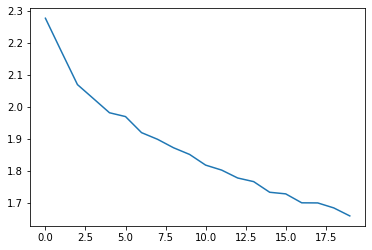

In [86]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)
plt.plot(history.history["loss"])
plt.show()

In [87]:
near_neighbours_per_example = 10
embeddings = model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

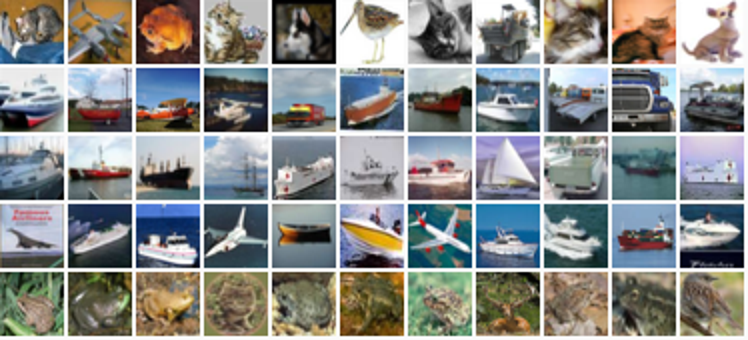

In [88]:
num_collage_examples = 5
examples = np.empty((
num_collage_examples, near_neighbours_per_example + 1, height_width, height_width, 3
), dtype=np.float32)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]
show_collage(examples)

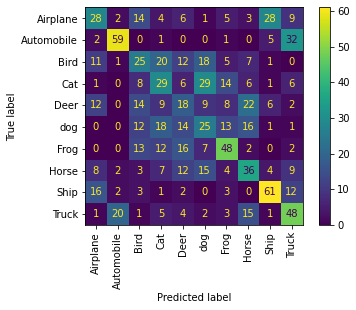

In [89]:
confusion_matrix = np.zeros((num_classes, num_classes))
for class_idx in range(num_classes):
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1
labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "dog", "Frog", "Horse", "Ship", "Truck"]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

# Project 22

In [1]:
import random
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_similarity as tfsim
tfsim.utils.tf_cap_memory()
print("Tensorflow:", tf.__version__)
print("Tensorflow Similarity:", tfsim.__version__)

Tensorflow: 2.8.0
Tensorflow Similarity: 0.15.8


In [2]:
num_known_classes = 10
class_list = random.sample(population=range(10), k = num_known_classes)
classes_per_batch = 10
examples_per_class_per_batch = 8
print(f"Batch size is: {min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}")

Batch size is: 80


In [3]:
class_list

[3, 5, 1, 2, 0, 4, 6, 9, 8, 7]

In [7]:
print("create training data".center(43, "#"))
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler("cifar10", 
            classes_per_batch=min(classes_per_batch, num_known_classes), splits="train", steps_per_epoch=4000, 
            examples_per_class_per_batch=examples_per_class_per_batch, class_list=class_list)
print("\n"+" Create validation Data".center(34, "#"))
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler("cifar10", classes_per_batch=classes_per_batch, splits="test", 
                                                       total_examples_per_class=100)

############create training data###########


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to C:\Users\jatin\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


converting train:   0%|          | 0/50000 [00:00<?, ?it/s]


The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50000 [00:00<?, ?it/s]


##### Create validation Data######


converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1000 [00:00<?, ?it/s]

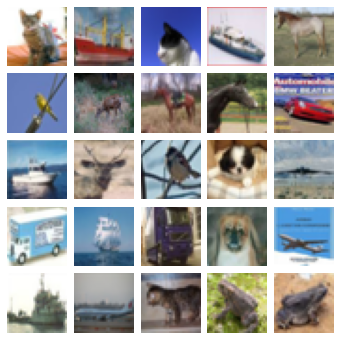

In [8]:
num_cols = num_rows = 5
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)
fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)
for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

In [9]:
embedding_size = 256
inputs = keras.layers.Input((32, 32, 3))
x = keras.layers.Rescaling(scale=1.0/255)(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                  

In [10]:
epochs = 3
learning_rate = 0.002
val_steps = 50
loss = tfsim.losses.MultiSimilarityLoss()
model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/3
4000/4000 [==============================] - 2190s 548ms/step - loss: 2.2106 - val_loss: 0.9105
Warmup complete
Epoch 2/3
4000/4000 [==============================] - 2218s 554ms/step - loss: 1.8820 - val_loss: 0.8416
Epoch 3/3
4000/4000 [==============================] - 2987s 747ms/step - loss: 1.6202 - val_loss: 0.8035


In [11]:
x_index, y_index = val_ds.get_slice(begin=0, size=200)
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


In [13]:
x_train, y_train = train_ds.get_slice(begin=0, size=1000)
calibration = model.calibrate(x_train, y_train, calibration_metric="f1", matcher="match_nearest", 
                              extra_metrics=["precision", "recall", "binary_accuracy"], verbose=1)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/978 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy       f1
-------  -------  ----------  -----------  --------  -----------------  -------
optimal     0.95   0.0664313        0.904         1              0.904  0.94958



Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

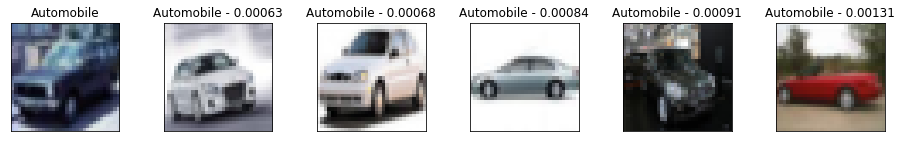

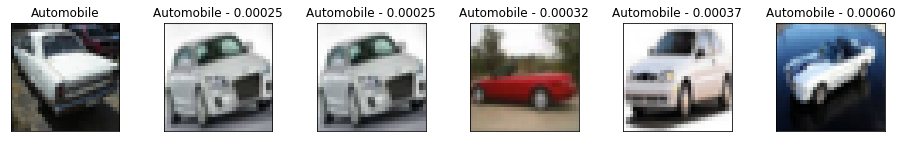

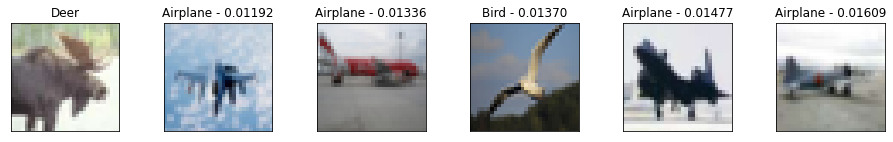

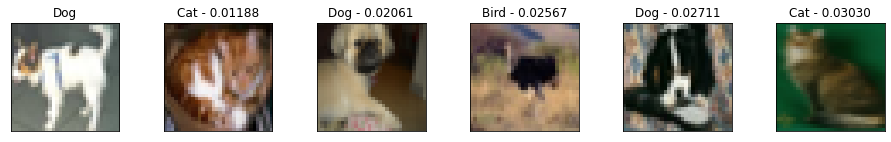

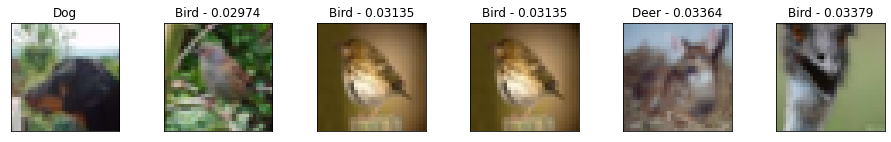

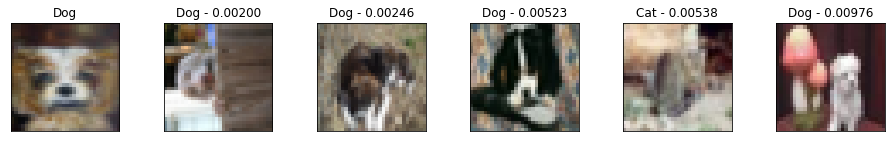

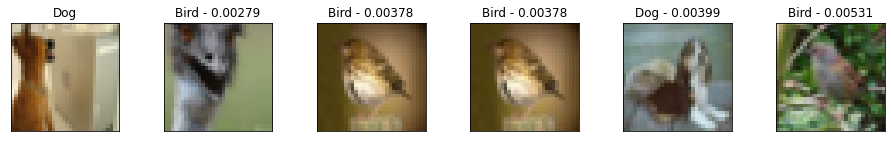

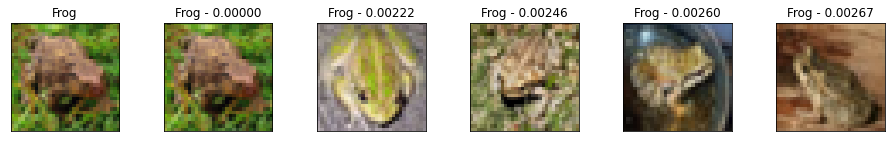

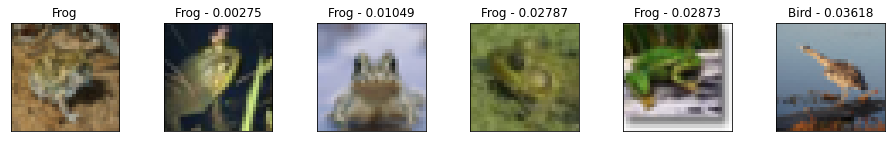

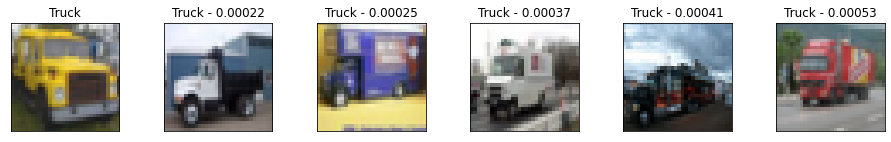

In [16]:
num_neighbors = 5
labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck", "Unknown"]
class_mapping = {c_id: c_lbl for c_id, c_lbl in zip(range(11), labels)}
x_display, y_display = val_ds.get_slice(begin=200, size=10)
nns = model.lookup(x_display, k=num_neighbors)
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                                           class_mapping=class_mapping, fig_size=(16, 2))
    

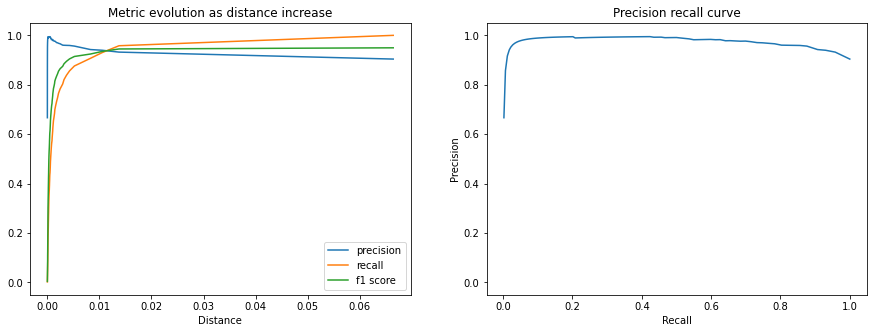

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = calibration.thresholds["distance"]
ax1.plot(x, calibration.thresholds["precision"], label="precision")
ax1.plot(x, calibration.thresholds["recall"], label="recall")
ax1.plot(x, calibration.thresholds["f1"], label="f1 score")
ax1.legend()
ax1.set_title("Metric evolution as distance increase")
ax1.set_xlabel("Distance")
ax1.set_ylim((-0.05, 1.05))

ax2.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax2.set_title("Precision recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_ylim((-0.05, 1.05))
plt.show()

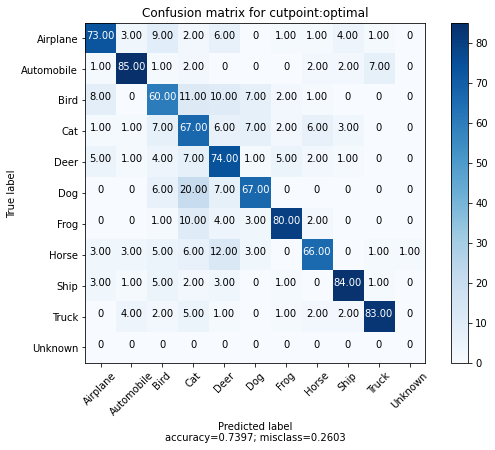

In [18]:
cutpoint = "optimal"
x_confusion, y_confusion = val_ds.get_slice(0, -1)
matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim.visualization.confusion_matrix(matches, y_confusion, labels=labels, 
                                          title="Confusion matrix for cutpoint:%s"%cutpoint, normalize=False)

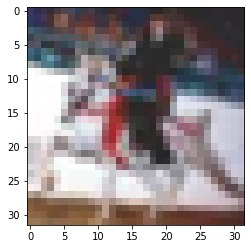

In [19]:
idx_no_match = np.where(np.array(matches) == 10)
no_match_queries = x_confusion[idx_no_match]
if len(no_match_queries):
    plt.imshow(no_match_queries[0])
else:
    print("All queries have a match below the distance threshold")

In [20]:
num_examples_to_clusters = 1000
thumb_size = 96
plot_size = 800
vx, vy = val_ds.get_slice(0, num_examples_to_clusters)
tfsim.visualization.projector(model.predict(vx), labels=vy, class_mapping=class_mapping, image_size=thumb_size, 
                              plot_size=plot_size)

perfoming projection using UMAP


Loading BokehJS ...

Loading BokehJS ...

# Project 23

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)
x_test = x_test.astype("float") // 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

In [11]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [12]:
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]
train_ds_one = (tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train)).shuffle(BATCH_SIZE * 100)
                .batch(BATCH_SIZE))
train_ds_two = (tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train)).shuffle(BATCH_SIZE*100)
               .batch(BATCH_SIZE))
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [15]:
def sample_beta_distribution(size, concentration_0 = 0.2, concentration_1 = 0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

def mix_up(ds_one, ds_two, alpha=0.2):
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999876618385315, 1.233816146850586e-05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9964883923530579, 0.0, 0.0, 0.0035116253420710564, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.521648108959198, 0.0, 0.478351891040802, 0.0, 0.0]
[0.0, 0.9976035952568054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00239640474319458]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.8511351346969604, 0.14886486530303955, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.04482609033584595, 0.0, 0.0, 0.0, 0.0, 0.955173909664154, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2801583409309387, 0.7198416590690613]
[0.0, 0.0, 0.0, 0.0, 0.0, 5.315260568750091e-05, 0.0, 0.0, 0.9999468326568604, 0.0]


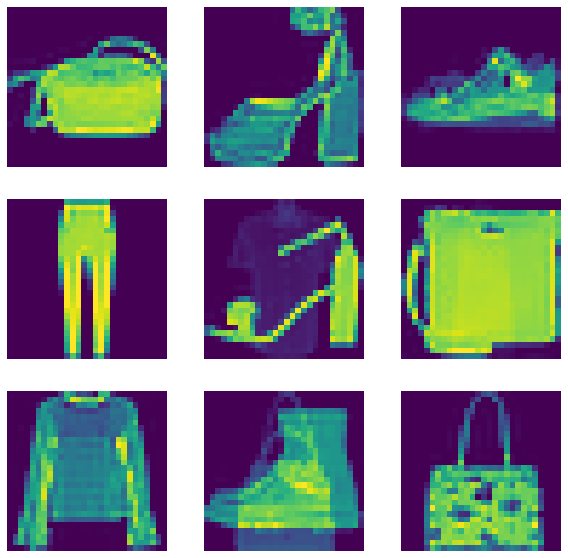

In [17]:
train_ds_mu = train_ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO)
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [18]:
def get_training_model():
    model = tf.keras.Sequential([
        layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.Conv2D(32, (5, 5), activation="relu"), 
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.2),
        layers.GlobalAvgPool2D(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    return model

In [19]:
initial_model = get_training_model()

In [21]:
model = get_training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 28s 30ms/step - loss: 1.2014 - accuracy: 0.6206 - val_loss: 0.7091 - val_accuracy: 0.7420
Epoch 2/10
907/907 [==============================] - 27s 29ms/step - loss: 0.9553 - accuracy: 0.7225 - val_loss: 0.5879 - val_accuracy: 0.7855
Epoch 3/10
907/907 [==============================] - 27s 29ms/step - loss: 0.8729 - accuracy: 0.7567 - val_loss: 0.5303 - val_accuracy: 0.8155
Epoch 4/10
907/907 [==============================] - 27s 29ms/step - loss: 0.8145 - accuracy: 0.7805 - val_loss: 0.4570 - val_accuracy: 0.8525
Epoch 5/10
907/907 [==============================] - 27s 29ms/step - loss: 0.7736 - accuracy: 0.7958 - val_loss: 0.4425 - val_accuracy: 0.8525
Epoch 6/10
907/907 [==============================] - 27s 29ms/step - loss: 0.7436 - accuracy: 0.8043 - val_loss: 0.4311 - val_accuracy: 0.8515
Epoch 7/10
907/907 [==============================] - 27s 30ms/step - loss: 0.7284 - accuracy: 0.8106 - val_loss: 0.4043 - val_accuracy:

In [23]:
model = get_training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}".format(test_acc*100))

Epoch 1/10
907/907 [==============================] - 29s 31ms/step - loss: 0.8991 - accuracy: 0.6659 - val_loss: 0.6617 - val_accuracy: 0.7625
Epoch 2/10
907/907 [==============================] - 28s 31ms/step - loss: 0.6424 - accuracy: 0.7564 - val_loss: 0.5680 - val_accuracy: 0.7850
Epoch 3/10
907/907 [==============================] - 28s 31ms/step - loss: 0.5695 - accuracy: 0.7864 - val_loss: 0.5055 - val_accuracy: 0.8275
Epoch 4/10
907/907 [==============================] - 27s 30ms/step - loss: 0.5193 - accuracy: 0.8064 - val_loss: 0.5011 - val_accuracy: 0.8220
Epoch 5/10
907/907 [==============================] - 29s 32ms/step - loss: 0.4808 - accuracy: 0.8236 - val_loss: 0.4502 - val_accuracy: 0.8415
Epoch 6/10
907/907 [==============================] - 28s 30ms/step - loss: 0.4475 - accuracy: 0.8362 - val_loss: 0.4041 - val_accuracy: 0.8645
Epoch 7/10
907/907 [==============================] - 28s 31ms/step - loss: 0.4236 - accuracy: 0.8445 - val_loss: 0.3804 - val_accuracy:

# Project 24

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [62]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [63]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


In [64]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [65]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [66]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [67]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

In [68]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [69]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/50
352/352 [==============================] - 450s 1s/step - loss: 3.8508 - acc: 0.1127 - top5-acc: 0.3239 - val_loss: 3.5922 - val_acc: 0.1680 - val_top5-acc: 0.4096 - lr: 0.0050
Epoch 2/50
352/352 [==============================] - 454s 1s/step - loss: 3.3713 - acc: 0.1888 - top5-acc: 0.4593 - val_loss: 3.3032 - val_acc: 0.2064 - val_top5-acc: 0.4854 - lr: 0.0050
Epoch 3/50
352/352 [==============================] - 466s 1s/step - loss: 3.1753 - acc: 0.2268 - top5-acc: 0.5172 - val_loss: 3.0477 - val_acc: 0.2536 - val_top5-acc: 0.5568 - lr: 0.0050
Epoch 4/50
352/352 [==============================] - 459s 1s/step - loss: 3.0217 - acc: 0.2553 - top5-acc: 0.5542 - val_loss: 2.9267 - val_acc: 0.2800 - val_top5-acc: 0.5804 - lr: 0.0050
Epoch 5/50
352/352 [==============================] - 455s 1s/step - loss: 2.8939 - acc: 0.2793 - top5-acc: 0.5862 - val_loss: 2.9537 - val_acc: 0.2722 - val_top5-acc: 0.5878 - lr: 0.0050
Epoch 6/50
352/352 [==============================] - 455s 1

In [70]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)
        self.ffn = keras.Sequential([
            layers.Dense(units=embedding_dim), 
            tfa.layers.GELU(),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(units=embedding_dim)
        ])
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs):
        x = tf.cast(tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)), dtype=tf.dtypes.float32)
        x = x + inputs
        x = self.normalize1(x)
        x_ffn = self.ffn(x)
        x = x + x_ffn
        return self.normalize2(x)

In [72]:
fnet_blocks = keras.Sequential([FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

Epoch 1/50
352/352 [==============================] - 743s 2s/step - loss: 4.1063 - acc: 0.0763 - top5-acc: 0.2389 - val_loss: 3.8144 - val_acc: 0.1230 - val_top5-acc: 0.3224 - lr: 0.0010
Epoch 2/50
352/352 [==============================] - 737s 2s/step - loss: 3.7139 - acc: 0.1292 - top5-acc: 0.3556 - val_loss: 3.5587 - val_acc: 0.1600 - val_top5-acc: 0.4086 - lr: 0.0010
Epoch 3/50
352/352 [==============================] - 739s 2s/step - loss: 3.4361 - acc: 0.1766 - top5-acc: 0.4364 - val_loss: 3.2528 - val_acc: 0.2106 - val_top5-acc: 0.4880 - lr: 0.0010
Epoch 4/50
352/352 [==============================] - 719s 2s/step - loss: 3.2215 - acc: 0.2146 - top5-acc: 0.4955 - val_loss: 3.0911 - val_acc: 0.2356 - val_top5-acc: 0.5258 - lr: 0.0010
Epoch 5/50
352/352 [==============================] - 720s 2s/step - loss: 3.0777 - acc: 0.2374 - top5-acc: 0.5342 - val_loss: 2.9267 - val_acc: 0.2658 - val_top5-acc: 0.5710 - lr: 0.0010
Epoch 6/50
352/352 [==============================] - 719s 2

In [73]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [74]:
gmlp_blocks = keras.Sequential([gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)

Epoch 1/50
352/352 [==============================] - 592s 2s/step - loss: 3.9300 - acc: 0.0960 - top5-acc: 0.2927 - val_loss: 3.5674 - val_acc: 0.1542 - val_top5-acc: 0.4130 - lr: 0.0030
Epoch 2/50
352/352 [==============================] - 591s 2s/step - loss: 3.4531 - acc: 0.1704 - top5-acc: 0.4356 - val_loss: 3.3390 - val_acc: 0.1920 - val_top5-acc: 0.4844 - lr: 0.0030
Epoch 3/50
352/352 [==============================] - 589s 2s/step - loss: 3.2632 - acc: 0.2044 - top5-acc: 0.4870 - val_loss: 3.1183 - val_acc: 0.2380 - val_top5-acc: 0.5248 - lr: 0.0030
Epoch 4/50
352/352 [==============================] - 590s 2s/step - loss: 3.0830 - acc: 0.2362 - top5-acc: 0.5324 - val_loss: 2.9722 - val_acc: 0.2704 - val_top5-acc: 0.5670 - lr: 0.0030
Epoch 5/50
352/352 [==============================] - 590s 2s/step - loss: 2.9423 - acc: 0.2606 - top5-acc: 0.5701 - val_loss: 2.8360 - val_acc: 0.2904 - val_top5-acc: 0.5972 - lr: 0.0030
Epoch 6/50
352/352 [==============================] - 591s 2

# Project 25

In [1]:
import tensorflow as tf
from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
tfds.disable_progress_bar()

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
patch_size = 4
image_size = 256
expansion_factor = 2

In [10]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same")
    return conv_layer(x)

def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)
    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)
    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1)
        x = layers.Add()([x3, x2])
    return x

def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(local_features, filters=projection_dim, kernel_size=1, strides=strides)
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(local_features)
    global_features = transformer_block(non_overlapping_patches, num_blocks, projection_dim)
    folded_features_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(global_features)
    folded_features_map = conv_block(folded_features_map, filters=x.shape[-1], kernel_size=1, strides=strides)
    local_global_features = layers.Concatenate(axis=-1)([x, folded_features_map])
    local_global_features = conv_block(local_global_features, filters=projection_dim, strides=strides)
    return local_global_features

In [12]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = conv_block(x, filters=16)
    x = inverted_residual_block(x, expanded_channels=16 * expansion_factor, output_channels=16)
    x = inverted_residual_block(x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2)
    x = inverted_residual_block(x, expanded_channels=24 * expansion_factor, output_channels=24)
    x = inverted_residual_block(x, expanded_channels=24 * expansion_factor, output_channels=24)
    x = inverted_residual_block(x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2)
    x = mobilevit_block(x, num_blocks=2, projection_dim=80)
    x = inverted_residual_block(x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2)
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)
mobilevit_xxs = create_mobilevit()
mobilevit_xxs.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 128, 128, 16  448         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 depthwise_conv2d_23 (Depthwise  (None, 64, 64, 48)  432         ['tf.nn.silu_46[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_47 (BatchN  (None, 64, 64, 48)  192         ['depthwise_conv2d_23[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 tf.nn.silu_47 (TFOpLambda)     (None, 64, 64, 48)   0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 64, 64, 24)   1152        ['tf.nn.silu_47[0][0]']          
          

 add_36 (Add)                   (None, 4, 256, 80)   0           ['dropout_21[0][0]',             
                                                                  'add_35[0][0]']                 
                                                                                                  
 reshape_9 (Reshape)            (None, 32, 32, 80)   0           ['add_36[0][0]']                 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 32, 32, 48)   3888        ['reshape_9[0][0]']              
                                                                                                  
 concatenate_3 (Concatenate)    (None, 32, 32, 96)   0           ['conv2d_68[0][0]',              
                                                                  'conv2d_71[0][0]']              
                                                                                                  
 conv2d_72

                                                                                                  
 layer_normalization_26 (LayerN  (None, 4, 64, 96)   192         ['add_40[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_13 (Multi  (None, 4, 64, 96)   74400       ['layer_normalization_26[0][0]', 
 HeadAttention)                                                   'layer_normalization_26[0][0]'] 
                                                                                                  
 add_41 (Add)                   (None, 4, 64, 96)    0           ['multi_head_attention_13[0][0]',
                                                                  'add_40[0][0]']                 
                                                                                                  
 layer_nor

In [13]:
batch_size = 64
auto = tf.data.AUTOTUNE
resize_bigger = 280
num_classes = 5
def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            image = tf.image.resize(image, (resize_bigger, resize_bigger))
            image = tf.image.random_crop(image, (image_size, image_size, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (image_size, image_size))
        label = tf.one_hot(label, depth=num_classes)
        return image, label
    return _pp

def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=auto)
    return dataset.batch(batch_size).prefetch(auto)

In [15]:
train_dataset, val_dataset = tfds.load("tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")
train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

Number of training examples: 3303
Number of validation examples: 367


In [17]:
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 30

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)
def run_experiment(epochs=epochs):
    mobilevit_xxs = create_mobilevit(num_classes=num_classes)
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
    mobilevit_xxs.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    _, acccuracy = mobilevit_xxs.evaluate(val_dataset)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}")
    return mobilevit_xxs
mobilevit_xxs = run_experiment()

Epoch 1/30
52/52 [==============================] - 4750s 91s/step - loss: 1.3222 - accuracy: 0.4790 - val_loss: 1.8284 - val_accuracy: 0.1907
Epoch 2/30
52/52 [==============================] - 4606s 89s/step - loss: 1.1202 - accuracy: 0.6037 - val_loss: 1.7994 - val_accuracy: 0.1907
Epoch 3/30
52/52 [==============================] - 4667s 89s/step - loss: 1.0708 - accuracy: 0.6533 - val_loss: 1.7954 - val_accuracy: 0.1907
Epoch 4/30
52/52 [==============================] - 4991s 96s/step - loss: 1.0166 - accuracy: 0.6827 - val_loss: 2.6157 - val_accuracy: 0.2071
Epoch 5/30
52/52 [==============================] - 5230s 101s/step - loss: 0.9633 - accuracy: 0.7145 - val_loss: 3.0312 - val_accuracy: 0.1907
Epoch 6/30
52/52 [==============================] - 5195s 100s/step - loss: 1.0012 - accuracy: 0.6794 - val_loss: 2.7340 - val_accuracy: 0.1907
Epoch 7/30
52/52 [==============================] - 5297s 102s/step - loss: 0.9572 - accuracy: 0.7163 - val_loss: 3.1754 - val_accuracy: 0.1

NameError: name 'accuracy' is not defined

In [18]:
mobilevit_xxs.save("mobilevit_xxs")
converter = tf.lite.TFLiteConverter.from_saved_model("mobilevit_xxs")
converter.optimizations = [tf.lite.optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
open("mobilevit_xxs.tflite", "wb").write(tflite_model)

AttributeError: module 'h5py' has no attribute 'File'

# Project 26

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [19]:
path_images = "/101_ObjectCategories/airplanes/"
path_annot = "/Annotations/Airplanes_Side_2/"
path_to_downloaded_file = keras.utils.get_file(fname="caltech_101_zipped", 
                            origin="https://data.caltech.edu/tindfiles/serve/e41f5188-0b32-41fa-801b-d1e840915e80", 
                                              extract=True, archive_format="zip", cache_dir="/")
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")
image_paths = [f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))]
annot_paths = [f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))]
image_paths.sort()
annot_paths.sort()
image_size = 224
images, targets = [], []
for i in range(0, len(annot_paths)):
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]
    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]
    image = keras.utils.load_img(path_images + image_paths[i])
    (w, h) = image.size[:2]
    if i < int(len(annot_paths) * 0.8):
        image = image.resize((image_size, image_size))
    images.append(keras.utils.img_to_array(image))
    targets.append((
        float(top_left_x) / w,
        float(top_left_y) / h,
        float(bottom_right_x) / w,
        float(bottom_right_y) / h,
    ))
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)])
)
(x_test), (y_test) = (np.asarray(images[int(len(images) * 0.8) :]), np.asarray(targets[int(len(targets) * 0.8) :]))

137428992/137414764 [==============================] - 18069s 131us/step


C:\Users\jatin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [32]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [33]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "input_shape":input_shape,
            "patch_size": patch_size,
            "num_patches":num_patches,
            "projection_dim":projection_dim,
            "num_heads":num_heads,
            "transformer_units":transformer_layers,
            "mlp_head_units":mlp_head_units,
        })
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], 
                                          strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], 
                                           padding="VALID")
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


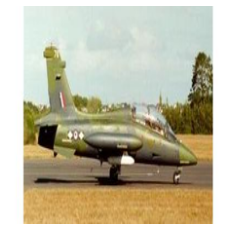

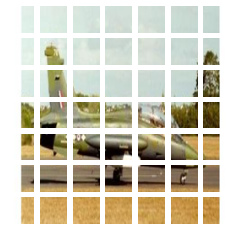

In [34]:
patch_size = 32
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [35]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "input_shape":input_shape,
            "patch_size":patch_size,
            "num_patches":num_patches,
            "projection_dim":projection_dim,
            "num_heads":num_heads,
            "transformer_units":transformer_units, 
            "transformer_layers":transformer_layers,
            "mlp_head_units":mlp_head_units,
        })
        return config
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [42]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [44]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 19s 591ms/step - loss: 0.8853 - val_loss: 0.3372
Epoch 2/100
18/18 [==============================] - 10s 542ms/step - loss: 0.3730 - val_loss: 0.2960
Epoch 3/100
18/18 [==============================] - 11s 639ms/step - loss: 0.2932 - val_loss: 0.2548
Epoch 4/100
18/18 [==============================] - 9s 521ms/step - loss: 0.2475 - val_loss: 0.2171
Epoch 5/100
18/18 [==============================] - 9s 530ms/step - loss: 0.2065 - val_loss: 0.1828
Epoch 6/100
18/18 [==============================] - 10s 572ms/step - loss: 0.1806 - val_loss: 0.1517
Epoch 7/100
18/18 [==============================] - 10s 563ms/step - loss: 0.1391 - val_loss: 0.1232
Epoch 8/100
18/18 [==============================] - 9s 528ms/step - loss: 0.1140 - val_loss: 0.0977
Epoch 9/100
18/18 [==============================] - 9s 517ms/step - loss: 0.0946 - val_loss: 0.0757
Epoch 10/100
18/18 [==============================] - 9s 525ms/step - loss: 0.0702 - v

mean_iou: 0.8690036253733784


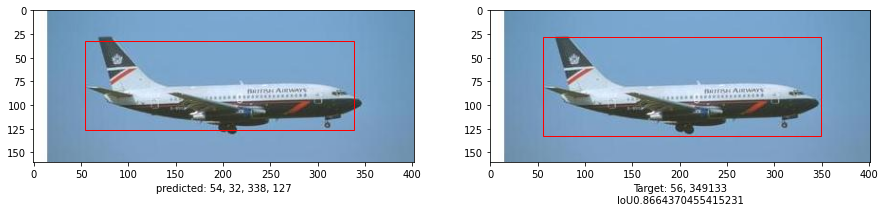

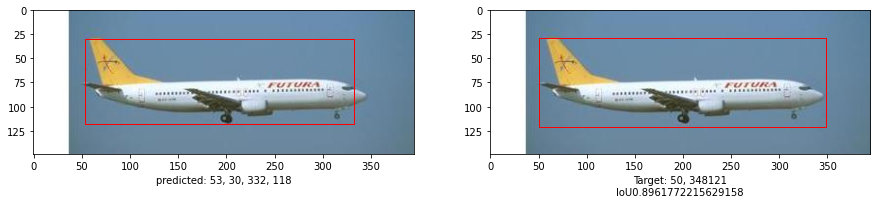

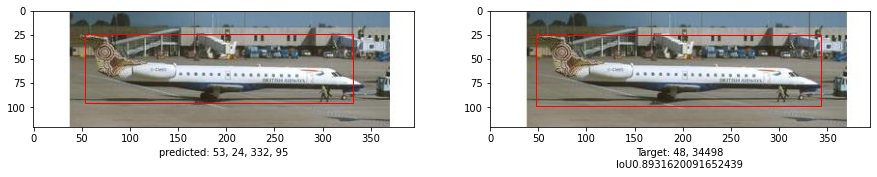

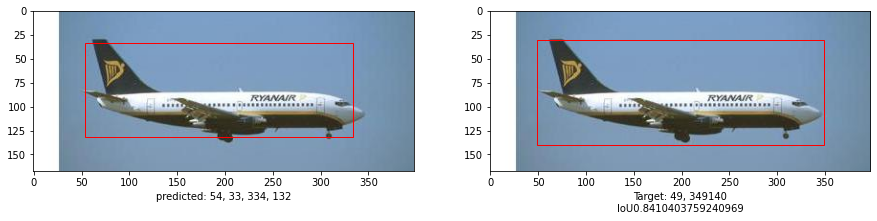

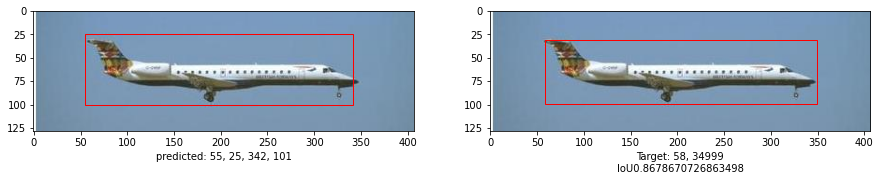

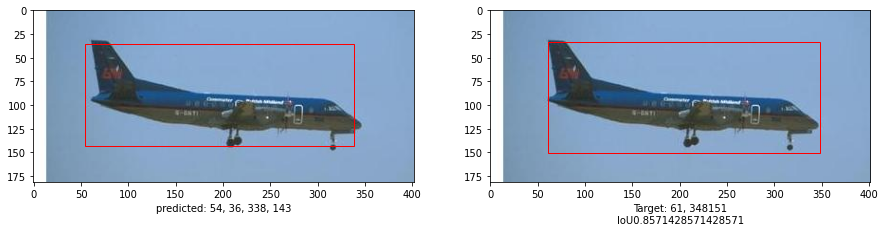

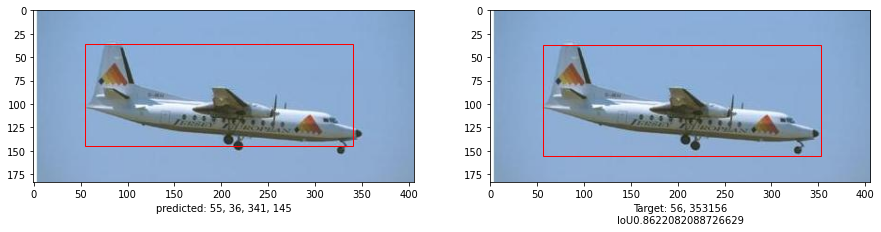

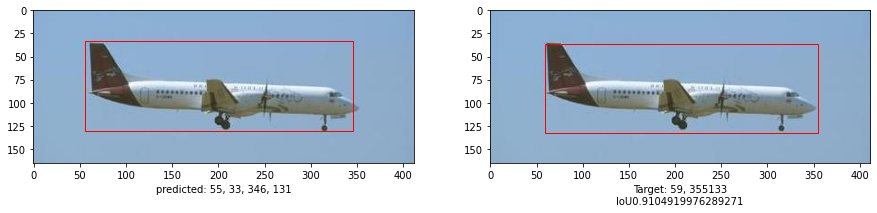

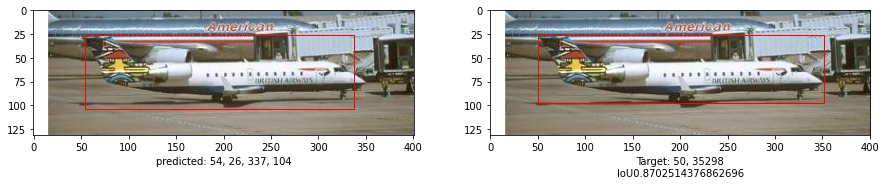

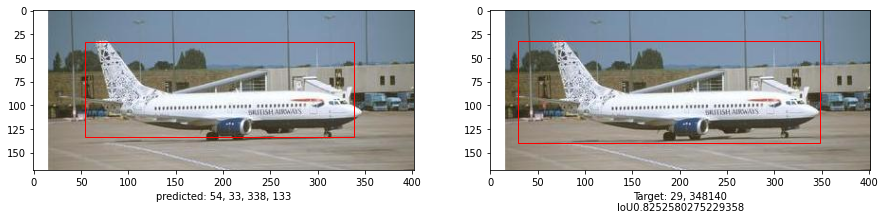

In [47]:
import matplotlib.patches as patches
# vit_object_detector.save("vit_object_detector.h5", save_format="h5")
def bounding_box_intersection_over_union(box_predicted, box_truth):
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(0, bottom_y_intersect - 
                                                                               top_y_intersect + 1)
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (box_predicted[3] - box_predicted[1] + 1)
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (box_truth[3] - box_truth[1] + 1)
    return intersection_area / float(box_predicted_area + box_truth_area - intersection_area)
i, mean_iou = 0, 0
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))
    input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]
    (h, w) = (im).shape[0:2]
    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)
    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)
    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y,
                            facecolor = "none", edgecolor="red", linewidth=1)
    ax1.add_patch(rect)
    ax1.set_xlabel("predicted: " + str(top_left_x) + ", " + str(top_left_y) + ", " + str(bottom_right_x) + ", " + 
                  str(bottom_right_y))
    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)
    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)
    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y
    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    rect =patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, 
                            facecolor="none", edgecolor="red", linewidth=1)
    ax2.add_patch(rect)
    ax2.set_xlabel("Target: " + str(top_left_x) + ", " + str(bottom_right_x) + str(bottom_right_y) + "\n" + "IoU" +
                  str(bounding_box_intersection_over_union(box_predicted, box_truth)))
    i = i + 1
print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

# Project 27

In [48]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
SEED = 42
keras.utils.set_random_seed(SEED)

In [49]:
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10
IMAGE_SIZE = 48
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [51]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = ((x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:]))
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [52]:
def get_preprocessing():
    model = keras.Sequential([layers.Rescaling(1/255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), ], 
                             name="preprocessing")
    return model

def get_train_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
    ], name="train_data_augmentation")
    return model

In [61]:
def build_convolutional_stem(dimensions):
    config = {"kernel_size": (3, 3), 
             "strides":(2, 2), 
             "activation":tf.nn.gelu, 
             "padding": "same"}
    convolutional_stem = keras.Sequential([
        layers.Conv2D(filters=dimensions // 2, **config), 
        layers.Conv2D(filters=dimensions, **config), 
    ], name="convolutional_stem")
    return convolutional_stem

In [62]:
class SqueezeExcite(layers.Layer):
    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
    
    def get_config(self):
        congfig = super().get_config()
        config.update({"ratio":self.ratio})
        return config
    
    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(units=filters // self.ratio, activation="relu", use_bias=False)
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()
    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

class Trunk(layers.Layer):
    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth
    def get_config(self):
        config = super().get_config()
        config.update({
            "ratio":self.ratio,
            "dimensions":self.dimensions, 
            "depth":self.depth
        })
        return config
    def build(self, input_shape):
        config = {
            "filters":self.dimensions, 
            "activation":tf.nn.gelu,
            "padding":"same"
        }
        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6), 
            layers.Conv2D(kernel_size=(1, 1), **config), 
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same")
        ]
        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))
    def call(self, x):
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        x = self.flatten_spatial(x)
        return x

In [68]:
class AttentionPooling(layers.Layer):
    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))
    def get_config(self):
        config = super().get_config()
        config.update({
            "dimensions":self.dimensions, 
            "num_classes":self.num_classes, 
            "cls":self.cls.numpy()
        })
        return config
    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(num_heads=1, key_dim=self.dimensions, dropout=0.2)
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            layers.Dropout(0.2),
            layers.Dense(units=self.dimensions, activation=tf.nn.gelu)
        ])
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()
    def call(self, x):
        batch_size = tf.shape(x)[0]
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        x = tf.concat([class_token, x], axis=1)
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(query=x[:, 0:1], key=x, value=x, return_attention_scores=True)
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]

In [73]:
class PatchConvNet(keras.Model):
    def __init__(self, stem, trunk, attention_pooling, preprocessing_model, train_augmentation_model, **kwargs):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk=trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model
    def get_config(self):
        config = super().get_config()
        config.update({
            "stem": self.stem,
            "trunk":self.trunk,
            "attention_pooling":self.attention_pooling, 
            "train_augmentation_model":self.train_augmentation_model,
            "preprocessing_model": self.preprocessing_model
        })
        return config
    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        x = self.stem(augmented_images)
        x = self.trunk(x)
        logits, _ = self.attention_pooling(x)
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits
    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        train_vars = [
            self.stem.trainable_variables, 
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}
    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}
    def call(self, images):
        augmented_images = self.preprocessing_model(images)
        x = self.stem(augmented_images)
        x = self.trunk(x)
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights

In [83]:
test_images, test_labels = next(iter(test_ds))

class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval
    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            test_x = self.model.stem(test_augmented_images)
            test_x = self.model.trunk(test_x)
            _, test_viz_weights = self.model.attention_pooling(test_x)
            num_patches = tf.shape(test_viz_weights)[-1]
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6)
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()

In [84]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)
    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total steps must be lateger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(self.pi * (tf.cast(step, tf.float32) - self.warmup_steps) / float(self.total_steps - 
                                                                self.warmup_steps))
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError("Learning_rate_base must be larger or equal to warmup_learning_rate.")
            slope = (self.learning_rate_base - self.warmup_learning_rate) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(step < self.warmup_steps, warmup_rate, learning_rate)
        return tf.where(step > self.total_steps, 0.0, learning_rate, name="learning_rate")

total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(learning_rate_base=LEARNING_RATE, total_steps=total_steps, warmup_learning_rate=0.0, 
                            warmup_steps=warmup_steps)

Epoch 1/50
313/313 [==============================] - 982s 3s/step - loss: 1.9989 - accuracy: 0.2494 - top-5-accuracy: 0.7739 - val_loss: 1.7694 - val_accuracy: 0.3190 - val_top-5-accuracy: 0.8587
Epoch 2/50
313/313 [==============================] - 943s 3s/step - loss: 1.5447 - accuracy: 0.4232 - top-5-accuracy: 0.9091 - val_loss: 1.3990 - val_accuracy: 0.4798 - val_top-5-accuracy: 0.9309
Epoch 3/50
313/313 [==============================] - 969s 3s/step - loss: 1.3196 - accuracy: 0.5209 - top-5-accuracy: 0.9383 - val_loss: 1.2679 - val_accuracy: 0.5306 - val_top-5-accuracy: 0.9523
Epoch 4/50
313/313 [==============================] - 992s 3s/step - loss: 1.1445 - accuracy: 0.5890 - top-5-accuracy: 0.9552 - val_loss: 1.2251 - val_accuracy: 0.5731 - val_top-5-accuracy: 0.9447
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.6411 - top-5-accuracy: 0.9687

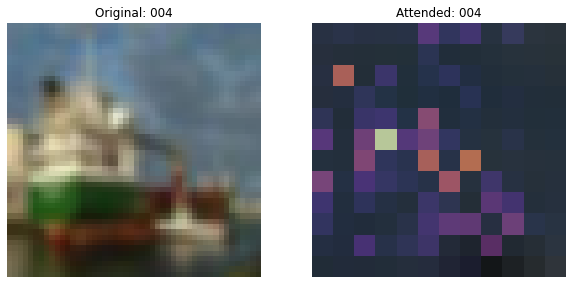

313/313 [==============================] - 1111s 4s/step - loss: 1.0034 - accuracy: 0.6411 - top-5-accuracy: 0.9687 - val_loss: 1.0779 - val_accuracy: 0.6266 - val_top-5-accuracy: 0.9682
Epoch 6/50
313/313 [==============================] - 981s 3s/step - loss: 0.8766 - accuracy: 0.6891 - top-5-accuracy: 0.9762 - val_loss: 0.9864 - val_accuracy: 0.6548 - val_top-5-accuracy: 0.9733
Epoch 7/50
313/313 [==============================] - 952s 3s/step - loss: 0.7903 - accuracy: 0.7232 - top-5-accuracy: 0.9824 - val_loss: 0.8781 - val_accuracy: 0.6921 - val_top-5-accuracy: 0.9735
Epoch 8/50
313/313 [==============================] - 972s 3s/step - loss: 0.6845 - accuracy: 0.7624 - top-5-accuracy: 0.9876 - val_loss: 0.8911 - val_accuracy: 0.6953 - val_top-5-accuracy: 0.9753
Epoch 9/50
313/313 [==============================] - 951s 3s/step - loss: 0.6003 - accuracy: 0.7890 - top-5-accuracy: 0.9908 - val_loss: 0.9342 - val_accuracy: 0.6974 - val_top-5-accuracy: 0.9743
Epoch 10/50
313/313 [====

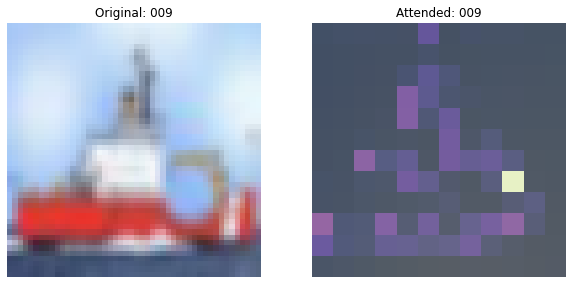

313/313 [==============================] - 942s 3s/step - loss: 0.5176 - accuracy: 0.8191 - top-5-accuracy: 0.9940 - val_loss: 0.9525 - val_accuracy: 0.7037 - val_top-5-accuracy: 0.9755
Epoch 11/50
313/313 [==============================] - 968s 3s/step - loss: 0.4462 - accuracy: 0.8426 - top-5-accuracy: 0.9959 - val_loss: 1.0727 - val_accuracy: 0.6916 - val_top-5-accuracy: 0.9678
Epoch 12/50
313/313 [==============================] - 1000s 3s/step - loss: 0.3949 - accuracy: 0.8626 - top-5-accuracy: 0.9970 - val_loss: 0.9423 - val_accuracy: 0.7290 - val_top-5-accuracy: 0.9774
Epoch 13/50
313/313 [==============================] - 958s 3s/step - loss: 0.3422 - accuracy: 0.8808 - top-5-accuracy: 0.9980 - val_loss: 1.0077 - val_accuracy: 0.7129 - val_top-5-accuracy: 0.9737
Epoch 14/50
313/313 [==============================] - 936s 3s/step - loss: 0.2936 - accuracy: 0.8977 - top-5-accuracy: 0.9988 - val_loss: 1.0595 - val_accuracy: 0.7105 - val_top-5-accuracy: 0.9717
Epoch 15/50
313/313 [

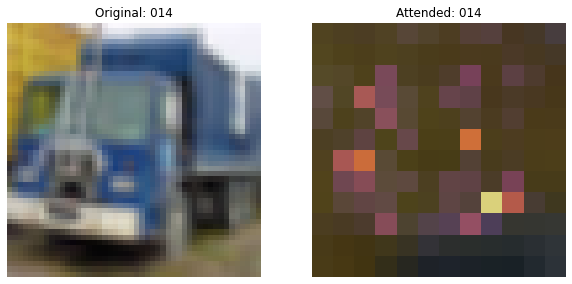

313/313 [==============================] - 943s 3s/step - loss: 0.2686 - accuracy: 0.9054 - top-5-accuracy: 0.9991 - val_loss: 1.0871 - val_accuracy: 0.7121 - val_top-5-accuracy: 0.9741
Epoch 16/50
313/313 [==============================] - 944s 3s/step - loss: 0.2226 - accuracy: 0.9212 - top-5-accuracy: 0.9994 - val_loss: 1.1479 - val_accuracy: 0.7046 - val_top-5-accuracy: 0.9746
Epoch 17/50
313/313 [==============================] - 954s 3s/step - loss: 0.1964 - accuracy: 0.9306 - top-5-accuracy: 0.9995 - val_loss: 1.0781 - val_accuracy: 0.7246 - val_top-5-accuracy: 0.9756
Epoch 18/50
313/313 [==============================] - 944s 3s/step - loss: 0.1825 - accuracy: 0.9373 - top-5-accuracy: 0.9996 - val_loss: 1.1838 - val_accuracy: 0.7169 - val_top-5-accuracy: 0.9763
Epoch 19/50
313/313 [==============================] - 935s 3s/step - loss: 0.1617 - accuracy: 0.9441 - top-5-accuracy: 0.9997 - val_loss: 1.1587 - val_accuracy: 0.7111 - val_top-5-accuracy: 0.9713
Epoch 20/50
313/313 [=

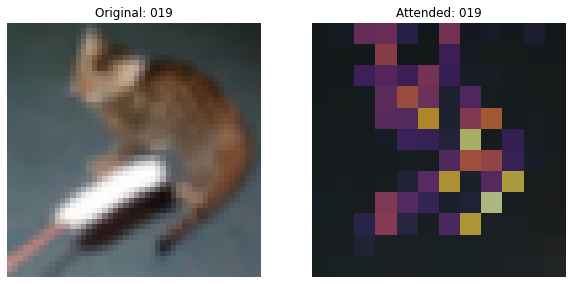

313/313 [==============================] - 937s 3s/step - loss: 0.1512 - accuracy: 0.9473 - top-5-accuracy: 0.9999 - val_loss: 1.1338 - val_accuracy: 0.7185 - val_top-5-accuracy: 0.9759
Epoch 21/50
313/313 [==============================] - 940s 3s/step - loss: 0.1397 - accuracy: 0.9512 - top-5-accuracy: 0.9999 - val_loss: 1.2167 - val_accuracy: 0.7191 - val_top-5-accuracy: 0.9732
Epoch 22/50
313/313 [==============================] - 941s 3s/step - loss: 0.1267 - accuracy: 0.9560 - top-5-accuracy: 1.0000 - val_loss: 1.1629 - val_accuracy: 0.7286 - val_top-5-accuracy: 0.9783
Epoch 23/50
313/313 [==============================] - 945s 3s/step - loss: 0.1139 - accuracy: 0.9603 - top-5-accuracy: 0.9999 - val_loss: 1.1532 - val_accuracy: 0.7323 - val_top-5-accuracy: 0.9773
Epoch 24/50
313/313 [==============================] - 948s 3s/step - loss: 0.0971 - accuracy: 0.9665 - top-5-accuracy: 0.9999 - val_loss: 1.3890 - val_accuracy: 0.7007 - val_top-5-accuracy: 0.9748
Epoch 25/50
313/313 [=

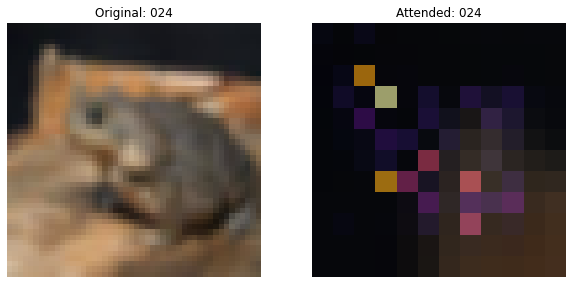

313/313 [==============================] - 934s 3s/step - loss: 0.0980 - accuracy: 0.9653 - top-5-accuracy: 1.0000 - val_loss: 1.1703 - val_accuracy: 0.7391 - val_top-5-accuracy: 0.9801
Epoch 26/50
313/313 [==============================] - 935s 3s/step - loss: 0.0802 - accuracy: 0.9725 - top-5-accuracy: 0.9999 - val_loss: 1.2765 - val_accuracy: 0.7386 - val_top-5-accuracy: 0.9717
Epoch 27/50
313/313 [==============================] - 933s 3s/step - loss: 0.0743 - accuracy: 0.9747 - top-5-accuracy: 0.9999 - val_loss: 1.2653 - val_accuracy: 0.7317 - val_top-5-accuracy: 0.9769
Epoch 28/50
313/313 [==============================] - 932s 3s/step - loss: 0.0703 - accuracy: 0.9756 - top-5-accuracy: 1.0000 - val_loss: 1.2844 - val_accuracy: 0.7310 - val_top-5-accuracy: 0.9747
Epoch 29/50
313/313 [==============================] - 934s 3s/step - loss: 0.0656 - accuracy: 0.9773 - top-5-accuracy: 1.0000 - val_loss: 1.2687 - val_accuracy: 0.7318 - val_top-5-accuracy: 0.9775
Epoch 30/50
313/313 [=

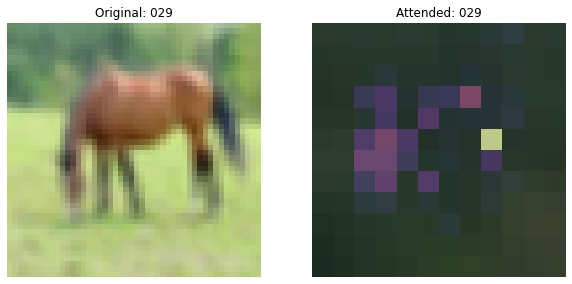

313/313 [==============================] - 937s 3s/step - loss: 0.0575 - accuracy: 0.9798 - top-5-accuracy: 1.0000 - val_loss: 1.3087 - val_accuracy: 0.7257 - val_top-5-accuracy: 0.9777
Epoch 31/50
313/313 [==============================] - 935s 3s/step - loss: 0.0407 - accuracy: 0.9860 - top-5-accuracy: 1.0000 - val_loss: 1.3498 - val_accuracy: 0.7357 - val_top-5-accuracy: 0.9768
Epoch 32/50
313/313 [==============================] - 932s 3s/step - loss: 0.0463 - accuracy: 0.9839 - top-5-accuracy: 1.0000 - val_loss: 1.3348 - val_accuracy: 0.7399 - val_top-5-accuracy: 0.9766
Epoch 33/50
313/313 [==============================] - 934s 3s/step - loss: 0.0382 - accuracy: 0.9867 - top-5-accuracy: 1.0000 - val_loss: 1.3628 - val_accuracy: 0.7406 - val_top-5-accuracy: 0.9708
Epoch 34/50
313/313 [==============================] - 933s 3s/step - loss: 0.0329 - accuracy: 0.9887 - top-5-accuracy: 1.0000 - val_loss: 1.3006 - val_accuracy: 0.7496 - val_top-5-accuracy: 0.9752
Epoch 35/50
313/313 [=

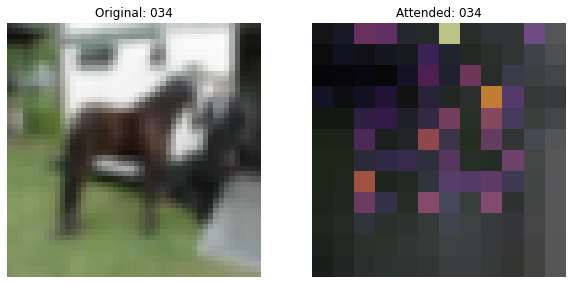

313/313 [==============================] - 933s 3s/step - loss: 0.0259 - accuracy: 0.9913 - top-5-accuracy: 1.0000 - val_loss: 1.3558 - val_accuracy: 0.7473 - val_top-5-accuracy: 0.9734
Epoch 36/50
313/313 [==============================] - 935s 3s/step - loss: 0.0205 - accuracy: 0.9933 - top-5-accuracy: 1.0000 - val_loss: 1.3751 - val_accuracy: 0.7497 - val_top-5-accuracy: 0.9741
Epoch 37/50
313/313 [==============================] - 935s 3s/step - loss: 0.0163 - accuracy: 0.9948 - top-5-accuracy: 1.0000 - val_loss: 1.3580 - val_accuracy: 0.7573 - val_top-5-accuracy: 0.9758
Epoch 38/50
313/313 [==============================] - 933s 3s/step - loss: 0.0126 - accuracy: 0.9960 - top-5-accuracy: 1.0000 - val_loss: 1.4482 - val_accuracy: 0.7493 - val_top-5-accuracy: 0.9709
Epoch 39/50
313/313 [==============================] - 932s 3s/step - loss: 0.0134 - accuracy: 0.9957 - top-5-accuracy: 1.0000 - val_loss: 1.3395 - val_accuracy: 0.7627 - val_top-5-accuracy: 0.9744
Epoch 40/50
313/313 [=

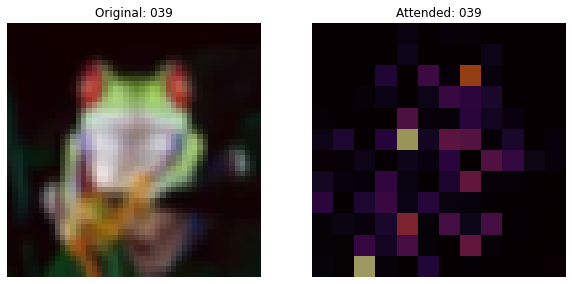

313/313 [==============================] - 932s 3s/step - loss: 0.0109 - accuracy: 0.9970 - top-5-accuracy: 1.0000 - val_loss: 1.3929 - val_accuracy: 0.7563 - val_top-5-accuracy: 0.9764
Epoch 41/50
313/313 [==============================] - 935s 3s/step - loss: 0.0110 - accuracy: 0.9967 - top-5-accuracy: 1.0000 - val_loss: 1.3537 - val_accuracy: 0.7598 - val_top-5-accuracy: 0.9763
Epoch 42/50
313/313 [==============================] - 934s 3s/step - loss: 0.0084 - accuracy: 0.9979 - top-5-accuracy: 1.0000 - val_loss: 1.2863 - val_accuracy: 0.7664 - val_top-5-accuracy: 0.9757
Epoch 43/50
313/313 [==============================] - 933s 3s/step - loss: 0.0055 - accuracy: 0.9993 - top-5-accuracy: 1.0000 - val_loss: 1.2834 - val_accuracy: 0.7590 - val_top-5-accuracy: 0.9750
Epoch 44/50
313/313 [==============================] - 933s 3s/step - loss: 0.0046 - accuracy: 0.9997 - top-5-accuracy: 1.0000 - val_loss: 1.2286 - val_accuracy: 0.7689 - val_top-5-accuracy: 0.9761
Epoch 45/50
313/313 [=

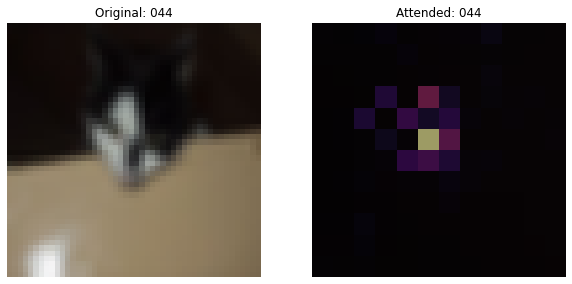

313/313 [==============================] - 937s 3s/step - loss: 0.0047 - accuracy: 0.9998 - top-5-accuracy: 1.0000 - val_loss: 1.2093 - val_accuracy: 0.7671 - val_top-5-accuracy: 0.9763
Epoch 46/50
313/313 [==============================] - 933s 3s/step - loss: 0.0060 - accuracy: 1.0000 - top-5-accuracy: 1.0000 - val_loss: 1.1925 - val_accuracy: 0.7647 - val_top-5-accuracy: 0.9765
Epoch 47/50
313/313 [==============================] - 933s 3s/step - loss: 0.0095 - accuracy: 0.9999 - top-5-accuracy: 1.0000 - val_loss: 1.1633 - val_accuracy: 0.7602 - val_top-5-accuracy: 0.9761
Epoch 48/50
313/313 [==============================] - 933s 3s/step - loss: 0.0158 - accuracy: 0.9998 - top-5-accuracy: 1.0000 - val_loss: 1.1184 - val_accuracy: 0.7592 - val_top-5-accuracy: 0.9771
Epoch 49/50
313/313 [==============================] - 934s 3s/step - loss: 0.0330 - accuracy: 0.9963 - top-5-accuracy: 1.0000 - val_loss: 1.0211 - val_accuracy: 0.7585 - val_top-5-accuracy: 0.9785
Epoch 50/50
313/313 [=

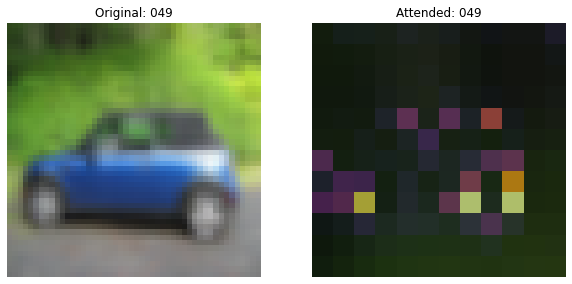

79/79 [==============================] - 56s 713ms/step - loss: 0.9306 - accuracy: 0.7529 - top-5-accuracy: 0.9767
Loss: 0.93
Top 1 test accuracy: 75.29%
Top 5 test accyracy: 97.67%


In [85]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)
patch_convnet = PatchConvNet(stem = conv_stem, trunk=conv_trunk, attention_pooling=attention_pooling, 
                            train_augmentation_model = train_augmentation_model, 
                             preprocessing_model=preprocessing_model)
train_callbacks = [TrainMonitor(epoch_interval=5)]
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
patch_convnet.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[
                         keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                         keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
                     ])
history = patch_convnet.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks)
loss, acc_top1, acc_top5 = patch_convnet.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1 * 100:0.2f}%")
print(f"Top 5 test accyracy: {acc_top5 * 100:0.2f}%")

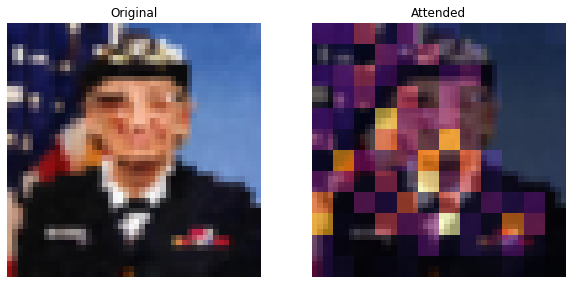

In [86]:
def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_convnet.preprocessing_model(image)
    # Pass through the stem.
    test_x = patch_convnet.stem(test_augmented_images)
    # Pass through the trunk.
    test_x = patch_convnet.trunk(test_x)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_convnet.attention_pooling(test_x)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    selected_image = test_augmented_images[0]
    selected_weight = test_viz_weights[0]
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
image_name = keras.utils.get_file(fname="image.jpg", origin=url)
image = tf.io.read_file(image_name)
image = tf.io.decode_image(image)
plot_attention(image)

# Project 28

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape}- y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)- y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [31]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 2  # Size of the patches to be extract from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
latent_dim = 256  # Size of the latent array.
projection_dim = 256  # Embedding size of each element in the data and latent arrays.
num_heads = 8  # Number of Transformer heads.
ffn_units = [
    projection_dim,
    projection_dim,
]  # Size of the Transformer Feedforward network.
num_transformer_blocks = 4
num_iterations = 2  # Repetitions of the cross-attention and Transformer modules.
classifier_units = [
    projection_dim,
    num_classes,
]  # Size of the Feedforward network of the final classifier.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")
print(f"Latent array shape: {latent_dim} X {projection_dim}")
print(f"Data array shape: {num_patches} X {projection_dim}")

Image size: 64 X 64 = 4096
Patch size: 2 X 2 = 4 
Patches per image: 1024
Elements per patch (3 channels): 12
Latent array shape: 256 X 256
Data array shape: 1024 X 256


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [33]:
def create_ffn(hidden_units, dropout_rate):
    ffn_layers = []
    for units in hidden_units[:-1]:
        ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    ffn_layers.append(layers.Dense(units=hidden_units[-1]))
    ffn_layers.append(layers.Dropout(dropout_rate))

    ffn = keras.Sequential(ffn_layers)
    return ffn

In [34]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [35]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [36]:
def create_cross_attention_module(
    latent_dim, data_dim, projection_dim, ffn_units, dropout_rate
):

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim)),
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = layers.Attention(use_scale=True, dropout=0.1)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attention_output = layers.Add()([attention_output, latent_array])

    # Apply layer norm.
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    # Apply Feedforward network.
    ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
    outputs = ffn(attention_output)
    # Skip connection 2.
    outputs = layers.Add()([outputs, attention_output])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [37]:
def create_transformer_module(
    latent_dim,
    projection_dim,
    num_heads,
    num_transformer_blocks,
    ffn_units,
    dropout_rate,
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        ffn = create_ffn(hidden_units=ffn_units, dropout_rate=dropout_rate)
        x3 = ffn(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=x0)
    return model

In [38]:
class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.
        self.patcher = Patches(self.patch_size)

        # Create patch encoder.
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super(Perceiver, self).build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patcher(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits

In [39]:
def run_experiment(model):

    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.LAMB(
        learning_rate=learning_rate, weight_decay_rate=weight_decay,
    )

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )

    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )

    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [ ]:
perceiver_classifier = Perceiver(patch_size, num_patches, latent_dim, projection_dim, num_heads, num_transformer_blocks,
                                ffn_units, dropout_rate, num_iterations, classifier_units)
history = run_experiment(perceiver_classifier)

Epoch 1/50
478/704 [===================>..........] - ETA: 7:33:32 - loss: 2.5683 - acc: 0.2377 - top5-acc: 0.6977

# Project 29

In [2]:
import os 
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [4]:
DATA_DIR = tf.keras.utils.get_file("modelnet.zip", 
                                   "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip", 
                                  extract=True)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 747s 2us/step


In [7]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

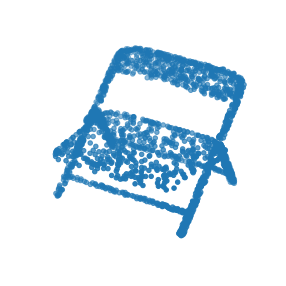

In [6]:
points = mesh.sample(2048)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [11]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    return (np.array(train_points), np.array(test_points), np.array(train_labels), np.array(test_labels), class_map)

In [12]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [14]:
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [21]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [22]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.eye = tf.eye(num_features)
        self.l2reg = l2reg
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [23]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(num_features * num_features, kernel_initializer="zeros", bias_initializer=bias, 
                     activity_regularizer=reg)(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [24]:
inputs = keras.Input(shape=(NUM_POINTS, 3))
x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

 activation_9 (Activation)      (None, 2048, 512)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 512)         0           ['activation_9[0][0]']           
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_3 (Dense)                (None, 256)          131328      ['global_max_pooling1d_1[0][0]'] 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 256)         1024        ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activatio

In [25]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), 
             metrics=["sparse_categorical_accuracy"])
model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 548s 5s/step - loss: 3.5988 - sparse_categorical_accuracy: 0.2434 - val_loss: 3876225989142904832.0000 - val_sparse_categorical_accuracy: 0.2689
Epoch 2/20
98/98 [==============================] - 535s 5s/step - loss: 2.8384 - sparse_categorical_accuracy: 0.4152 - val_loss: 5601179467776.0000 - val_sparse_categorical_accuracy: 0.2925
Epoch 3/20
98/98 [==============================] - 448s 5s/step - loss: 2.6861 - sparse_categorical_accuracy: 0.4389 - val_loss: 29910273884160.0000 - val_sparse_categorical_accuracy: 0.3019
Epoch 4/20
98/98 [==============================] - 444s 5s/step - loss: 2.5812 - sparse_categorical_accuracy: 0.4539 - val_loss: 2053058120908800.0000 - val_sparse_categorical_accuracy: 0.4717
Epoch 5/20
98/98 [==============================] - 443s 5s/step - loss: 2.4930 - sparse_categorical_accuracy: 0.4859 - val_loss: 4116423626457088.0000 - val_sparse_categorical_accuracy: 0.4277
Epoch 6/20
98/98 [==============

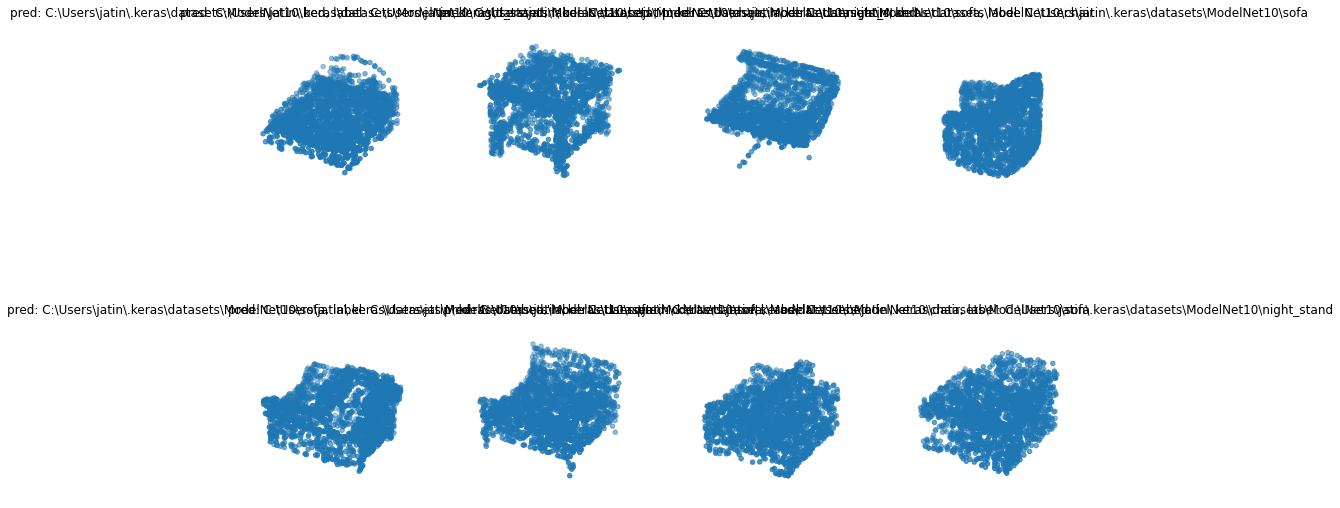

In [26]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)
points = points.numpy()
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title("pred: {:}, label: {:}".format(CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]))
    ax.set_axis_off()
plt.show()

# Project 30

In [35]:
import zipfile
from io import BytesIO
import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [36]:
RESOLUTION = 224
PATCH_SIZE = 16

In [37]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                       variance=[(0.229 * 255) ** 2, (0.224 *255) ** 2, (0.225 * 255) ** 2])
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)
def preprocess_image(image, model_type, size=RESOLUTION):
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    if model_type == "original_vit":
        image = rescale_layer(image)
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")
    image = crop_layer(image)
    if model_type != "original_vit":
        image = norm_layer(image)
    return image.numpy()
def load_image_from_url(url, model_type):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

32768/21675 [=============================================] - 0s 3us/step


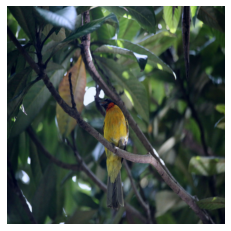

In [38]:
mapping_file = keras.utils.get_file(origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt")
with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")
plt.imshow(image)
plt.axis("off")
plt.show()

In [43]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model


vit_base_i21k_patch16_224 = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")
print("Model loaded.")

Downloading...
From: https://drive.google.com/uc?id=1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ
To: C:\Users\jatin\vit_b16_patch16_224.zip
100%|██████████| 322M/322M [26:31<00:00, 202kB/s]    


Model loaded.


In [44]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(preprocessed_image)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

bulbul


In [47]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:
                continue
            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])
    return distance_matrix

def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1
    attention_weights = attention_weights[..., num_cls_tokens:, num_cls_tokens:]
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length ** 2 == num_patches, "Num patches is not perfect square"
    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape
    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    mean_distances = attention_weights * distance_matrix
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(mean_distances, axis=-1)
    mean_distances = np.mean(mean_distances, axis=-1)
    return mean_distances

Num Heads: 12


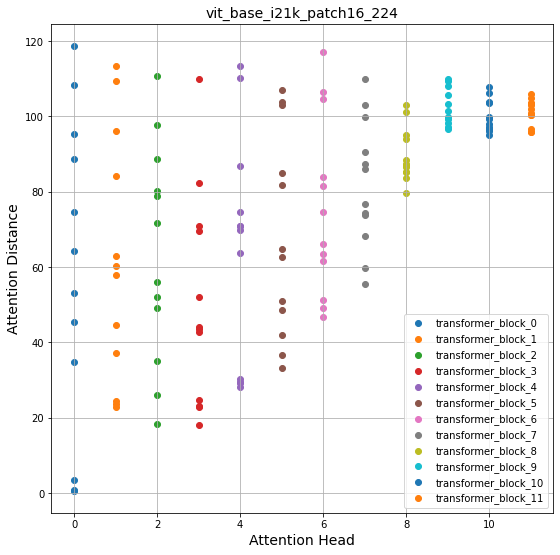

In [49]:
mean_distances = {f"{name}_mean_dist":compute_mean_attention_dist(patch_size=PATCH_SIZE, 
                                                                  attention_weights=attention_weight, 
                                                                  model_type="original_vit")
                 for name, attention_weight in attention_score_dict.items()}
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()
print(f"Num Heads: {num_heads}")
plt.figure(figsize=(9, 9))
for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")
plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

In [50]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)
    
    attn_mat = tf.reduce_mean(attn_mat, axis=1)
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()
    
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]
    
    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])
    
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result

<ipython-input-52-8c5f915d9aa8>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


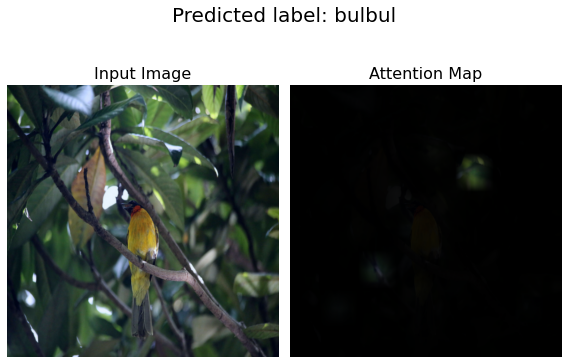

In [52]:
attn_rollout_result = attention_rollout_map(image, attention_score_dict, model_type="original_vit")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")
fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

In [53]:
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: C:\Users\jatin\vit_dino_base16.zip
100%|██████████| 326M/326M [24:18<00:00, 223kB/s] 


Model loaded.


In [56]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1
    
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)
    
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))
    attentions = tf.image.resize(attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE))
    return attentions

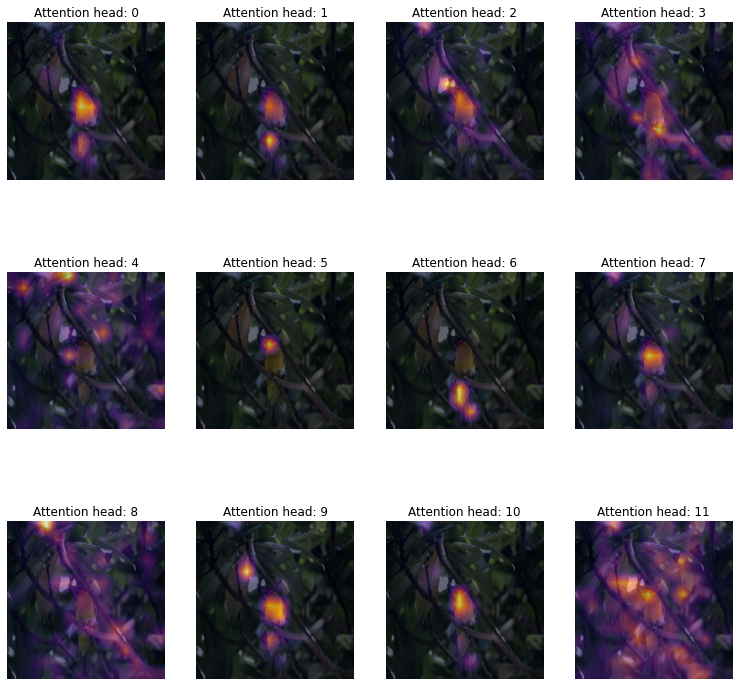

In [58]:
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

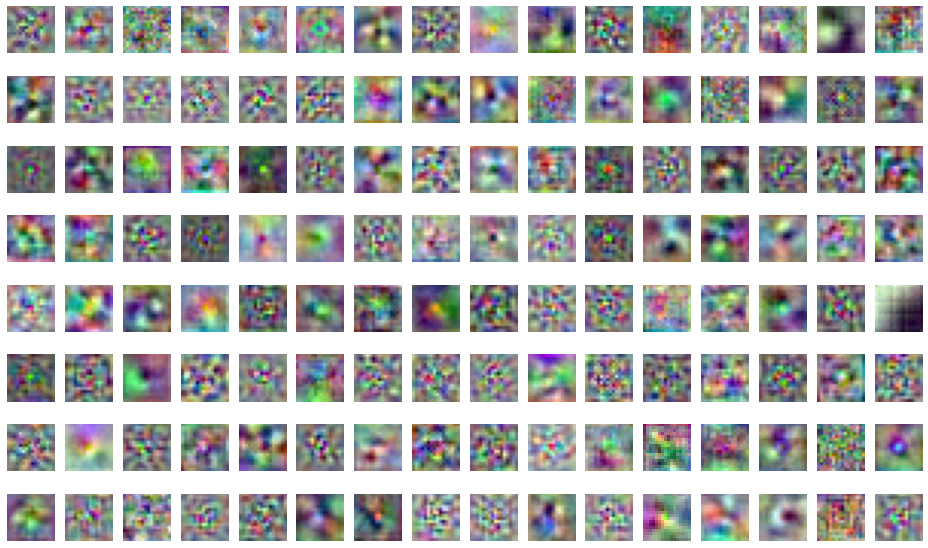

In [59]:
projections = (vit_base_i21k_patch16_224.layers[1]
              .get_layer("projection")
              .get_layer("conv_projection")
              .kernel.numpy())
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]
scaled_projections = MinMaxScaler().fit_transform(projections.reshape(-1, projection_dim))

scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)

fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1
fig.tight_layout()

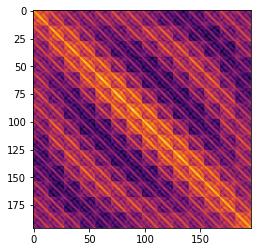

In [60]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()